In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Work flow
It is always helpful to structure your work first. Details could be adjusted when you found some insights in data.
1. EDA
2. Feature Engineering
3. Preprocessing for modeling
4. Build model

> # 1. EDA

# 1.1 Get General Idea About the Data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
print(train.head())
print(test.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [5]:
print('train shape',train.shape)
print('test shape',test.shape)
print('duplicated rows',train.duplicated().sum())
print('columns containing missing values',train.isnull().any().sum())

train shape (1460, 81)
test shape (1459, 80)
duplicated rows 0
columns containing missing values 19


In [6]:
test['SalePrice'] = np.nan
data_all = pd.concat([train,test],ignore_index=True)
print('merged shape ',data_all.shape)
print(data_all.info())

merged shape  (2919, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-nul

> Notes that it is important to distinguish the numerical variables from the categorical ones. 
* Here are some key takeaways:
1. The dtype only give us a big picture about the data are stored. However, it is still important to see whether there are some 'int' data is actually ordinal or nominal. For example, in this case, 'Id' should be nominal (or not consider as a feature), 'MSSubClass' can be ordinal or nominal depending on how you analyse it.
2. The corresponding visualization and analysis techniques can be different. For example, for numerical data, it is easy to compute the pearson correlation. On the other hand, using categories to draw different histogram is a nice way to show the distribution of our interested variable among the categories.
3. Here we use dtype == ['int','float'] to find numerical variables and 'object' to find categories. Numerical variables can be further split into "continuous" ones such as height, and "interval" ones such as decibel. Categorical variable can be split into "ordinal" and "nominal". Sometimes, ordinal ones can be translate into numbers to show their ranking. Nominal ones may need to be processed by one-hot encoding, therefore leads to undesired high dimension. So dealing with High Cardinality nominal variables is also an important part in feature engineering.
4. Time is an interesting feature, it would be helpful to store it as datatime64. However, first drawing out some lineplot against time would be nice to decide how to deal with it.

In [7]:
#This is a nice code to use at the very beginning
data_object = data_all.select_dtypes('object')
print('object shape ',data_object.shape)
data_num = data_all.select_dtypes(['int64','float64'])
print('num shape ',data_num.shape)

object shape  (2919, 43)
num shape  (2919, 38)


In [8]:
data_num.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2433.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    23.344905    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    59.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    68.000000    9453.000000     6.000000   
75%    2189.500000    70.000000    80.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000  ...   
mean      5.564577  1971.312778   1984.264474   102.201312   441.423235  ...   
std       1.113131    30.291442     20.894344   179.334253   455.610826  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.500000   1965.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1993.000000     0.000000   368.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   733.000000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  2919.000000  2919.000000    2919.000000  2919.000000  2919.000000   
mean     93.709832    47.486811      23.098321     2.602261    16.062350   
std     126.526589    67.575493      64.244246    25.188169    56.184365   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    26.000000       0.000000     0.000000     0.000000   
75%     168.000000    70.000000       0.000000     0.000000     0.000000   
max    1424.000000   742.000000    1012.000000   508.000000   576.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  2919.000000   2919.000000  2919.000000  2919.000000    1460.000000  
mean      2.251799     50.825968     6.213087  2007.792737  180921.195890  
std      35.663946    567.402211     2.714762     1.314964   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     4.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     800.000000  17000.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [9]:
for i in data_object.columns:
    print(data_object[i].value_counts())

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Pave    2907
Grvl      12
Name: Street, dtype: int64
Grvl    120
Pave     78
Name: Alley, dtype: int64
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, 

In [10]:
#Observed that some int features are not necessary continuous variable
#Should have checked first 

In [11]:
int_col = train.select_dtypes('int64').columns
def show_sample(column_list,row_range_start=0):
    i = 0
    while i < len(column_list):
        try:
            print(train[column_list[i:i+10]].iloc[row_range_start:row_range_start+10])
            i += 10
        except:
            print(train[column_list[i:]].iloc[row_range_start:row_range_start+10])
show_sample(int_col)

   Id  MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0   1          60     8450            7            5       2003          2003   
1   2          20     9600            6            8       1976          1976   
2   3          60    11250            7            5       2001          2002   
3   4          70     9550            7            5       1915          1970   
4   5          60    14260            8            5       2000          2000   
5   6          50    14115            5            5       1993          1995   
6   7          20    10084            8            5       2004          2005   
7   8          60    10382            7            6       1973          1973   
8   9          50     6120            7            5       1931          1950   
9  10         190     7420            5            6       1939          1950   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  
0         706           0        150  
1         978           0     

#  1.1.1 Some little feature engineering

In my first trial, I didn't notice that this processing could be done first. But in this case, it would be more clear to show EDA with some feature processed.

In [12]:
discrete_int = ['Id','MSSubClass']
time_int = ['YrSold','YearBuilt','YearRemodAdd','MoSold']

In [13]:
train[discrete_int] = train[discrete_int].astype('object')
data_all[discrete_int] = data_all[discrete_int].astype('object')

In [14]:
def get_num_features(df):
    num = list(df.select_dtypes(['int64','float64']).columns)
    try:
        num.remove('SalePrice')
    except:
        pass
    return num
def get_cat_features(df):
     return list(df.select_dtypes('object').columns)

In [15]:
num_train = train.select_dtypes(['int64','float64'])
object_train = train.select_dtypes('object')
num_train_corr = num_train.corr()

In [16]:
num_all = data_all.select_dtypes(['int64','float64'])
object_all = data_all.select_dtypes('object')
num_all_corr = num_all.corr()

#  1.2 EDA for Numerical Data

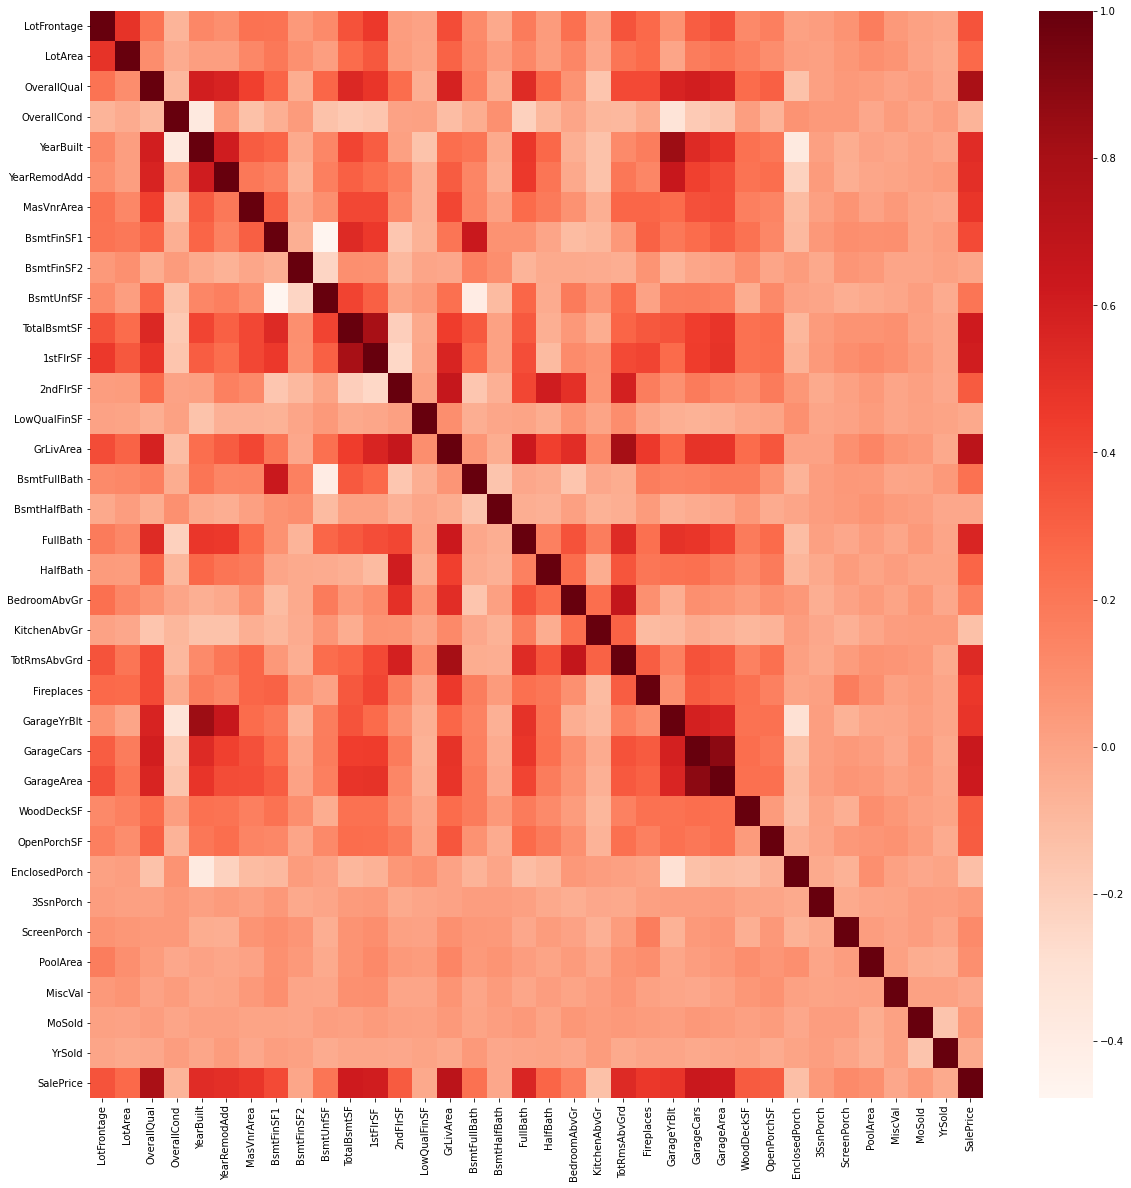

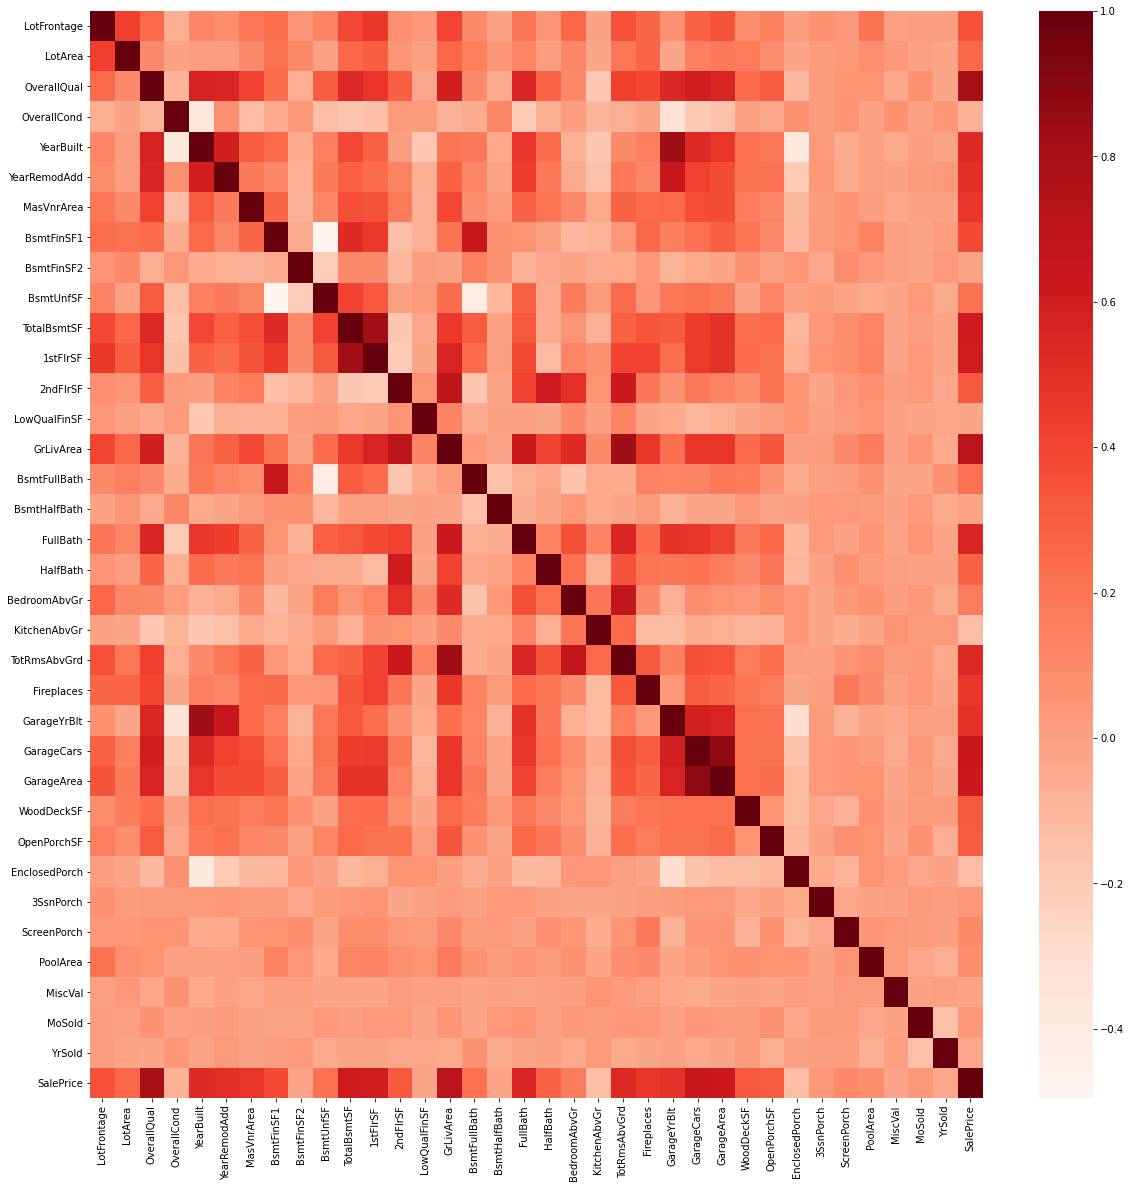

In [17]:
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(num_all_corr, cmap='Reds')
plt.show()
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(num_train_corr, cmap='Reds')
plt.show()
#1.Observed that OverallQual is correlated w/ lots of others
#2.As well as TotalBsmtSF, 1stFlrSF, GrLivArea
#3.Similar effects also happens to GarageYrBlt/Cars/Area
#and it's obvious that they are highly correlated with each other
#Lastly let's focus on the features that have the highest correlation with SalesPrice



['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']


<AxesSubplot:>

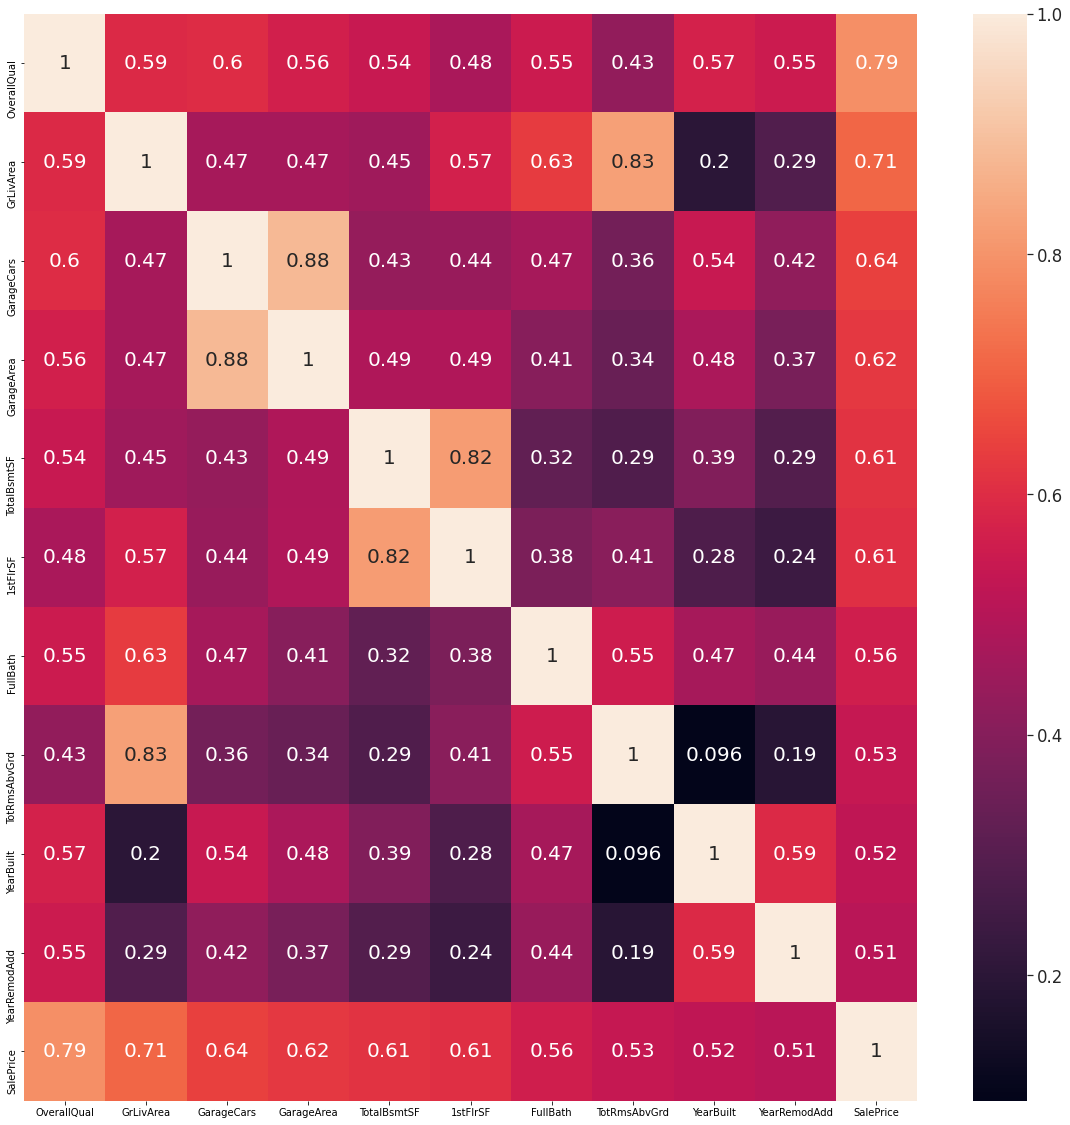

In [18]:
#rank the sign and correlationship
Correlation = pd.DataFrame(num_train.corr()['SalePrice'])
Correlation['Abs'] = np.abs(Correlation['SalePrice'])
Correlation = Correlation.sort_values(by='Abs',ascending=False)
#Most of the features are 'Positively' correlated with SalePrice
#Now use 0.5 as a threshold to pick out the important ones
important_features_CC = list(Correlation[Correlation['Abs'] > 0.5].index)
important_features_CC.remove('SalePrice')
print(important_features_CC)
#So now let's take a look at the details for the 10 mentioned ones in these sections
fig,ax=plt.subplots(figsize=(20,20))
sns.set(font_scale=1.5)
sns.heatmap(train[important_features_CC+['SalePrice']].corr(),annot=True,annot_kws={"size": 20})

In [19]:
#Since there are way too many variables with distinct definition
#We can start by learning some background knowledge of the data through these features.
#Here are some of the summary I would make at the beginning of EDA
data_all['GarageCars'].describe()
data_all['FullBath'].describe()
data_all['TotRmsAbvGrd'].describe()
data_all['YearBuilt'].describe()
data_all['YearRemodAdd'].describe()
# 
# 'OverallQual', 1-10 ratings summarizing the house
# 'GrLivArea', above ground area(feet^2)
# 'GarageCars', cars capacity(0-5)
# 'GarageArea', garage size area
# 'TotalBsmtSF', basement area(feet^2)
# '1stFlrSF', 1 flr area(feet^2)
# 'FullBath', amount of bathrooms above ground(1-4)
# 'TotRmsAbvGrd', amount of rooms above ground(2-15)
# 'YearBuilt', construction date,1872-2010
# 'YearRemodAdd', remodel date, 1950-2010
# 

count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

# 1.3 EDA for Categorical Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Categories for MSSubClass : 15


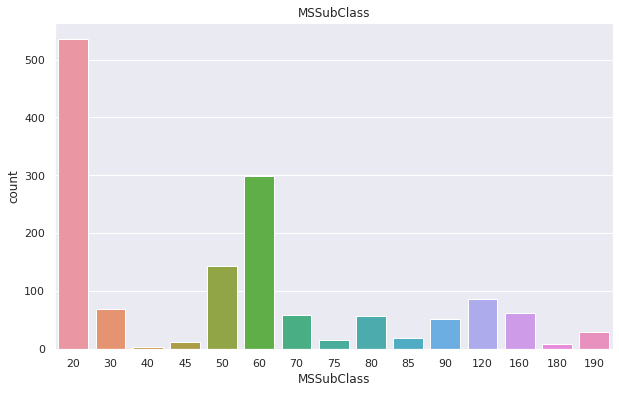

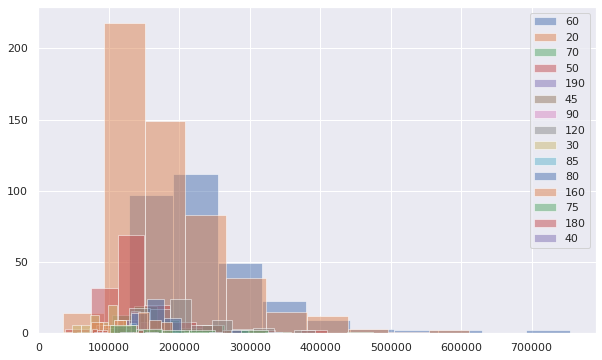

Categories for MSZoning : 5


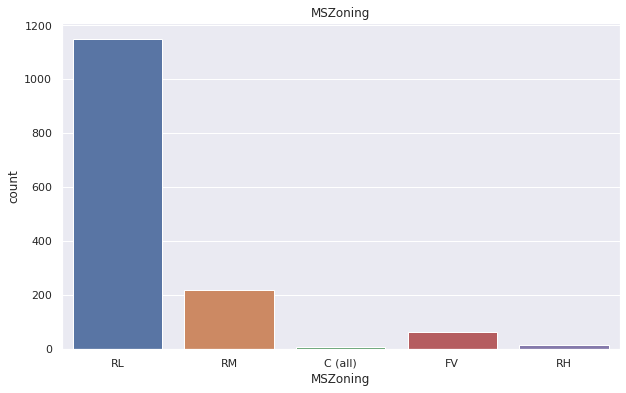

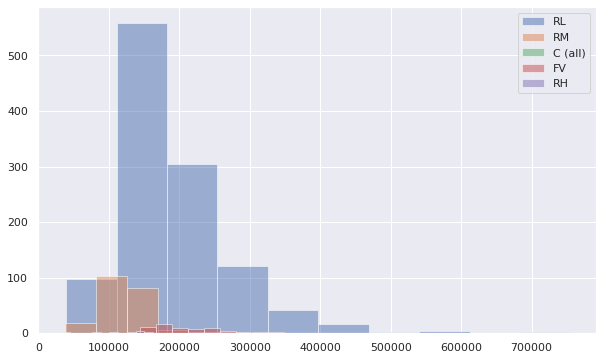

Categories for Street : 2


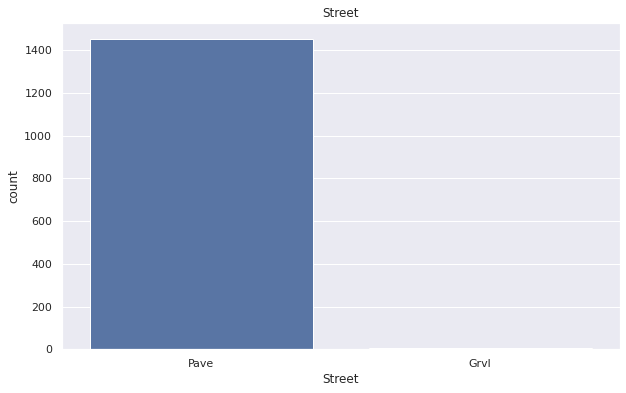

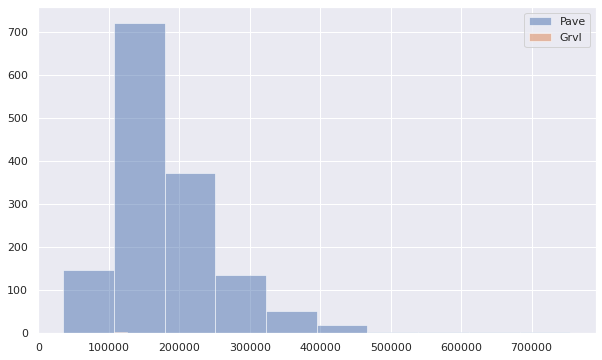

Categories for Alley : 3


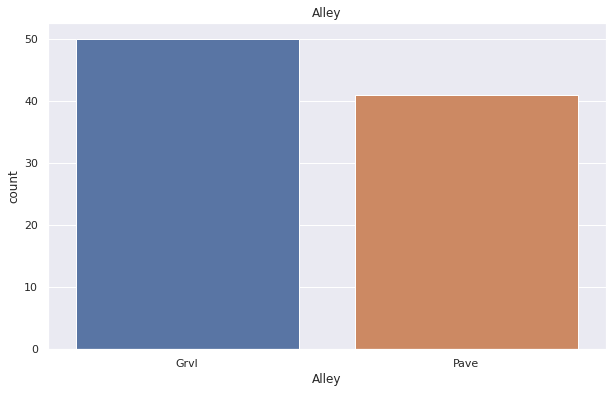

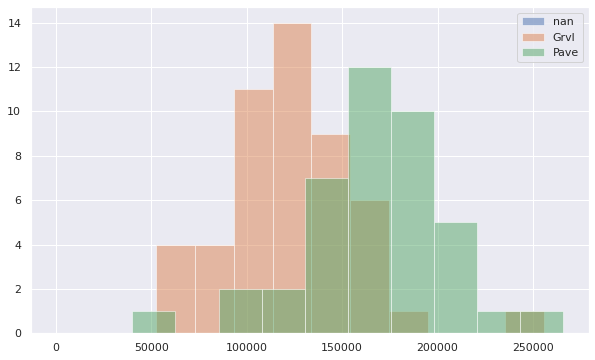

Categories for LotShape : 4


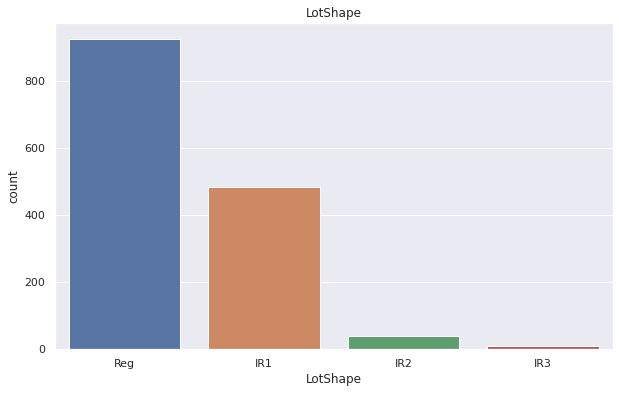

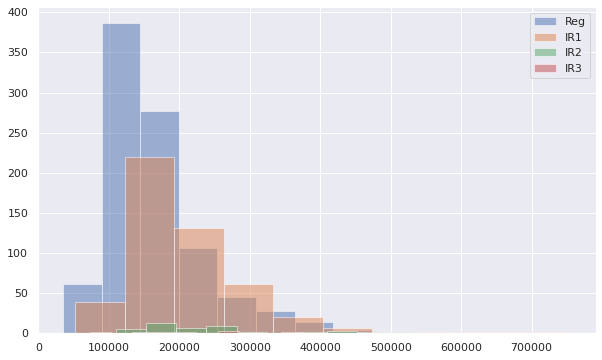

Categories for LandContour : 4


Categories for Utilities : 2


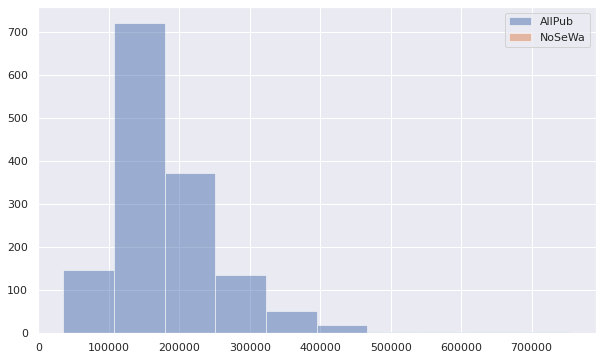

Categories for LotConfig : 5


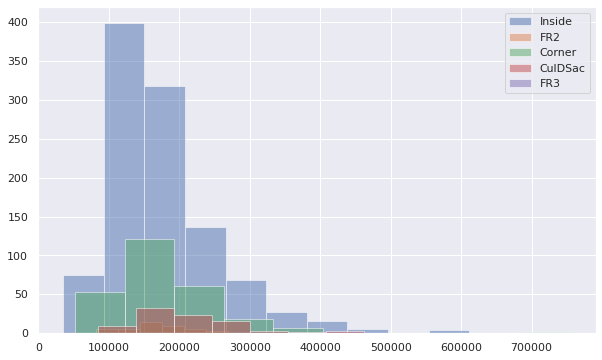

Categories for LandSlope : 3


Categories for Neighborhood : 25


Categories for Condition1 : 9


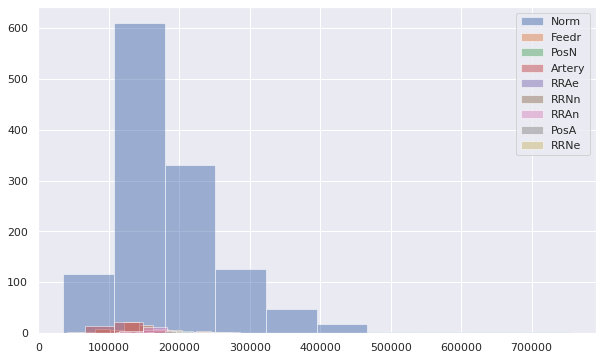

Categories for Condition2 : 8


Categories for BldgType : 5


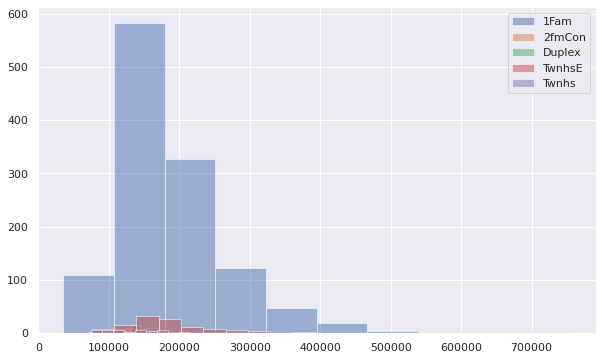

Categories for HouseStyle : 8


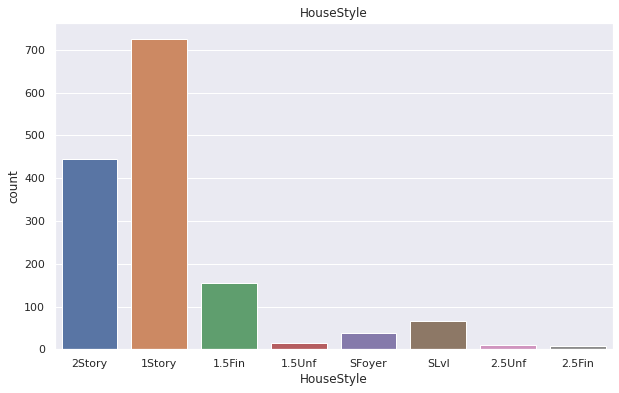

Categories for RoofStyle : 6


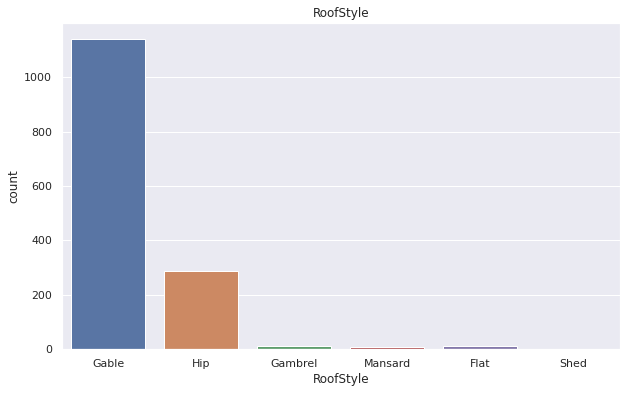

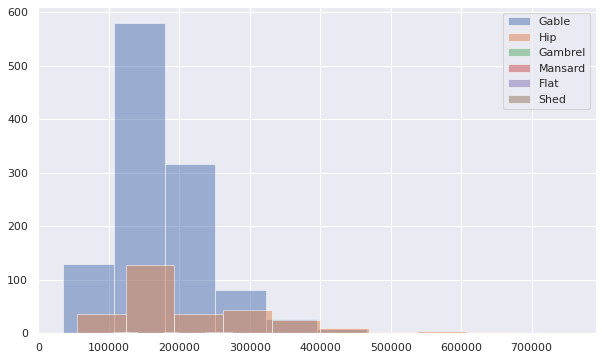

Categories for RoofMatl : 8


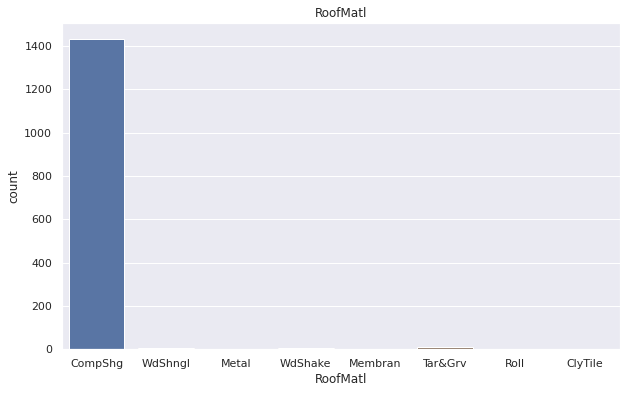

Categories for Exterior1st : 15


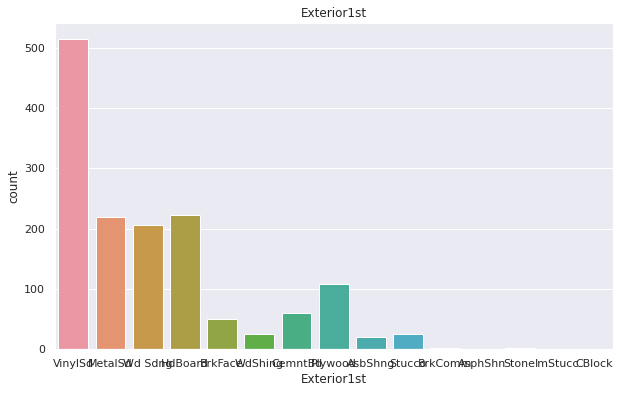

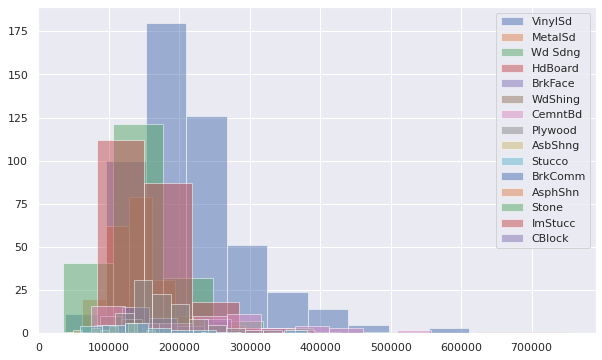

Categories for Exterior2nd : 16


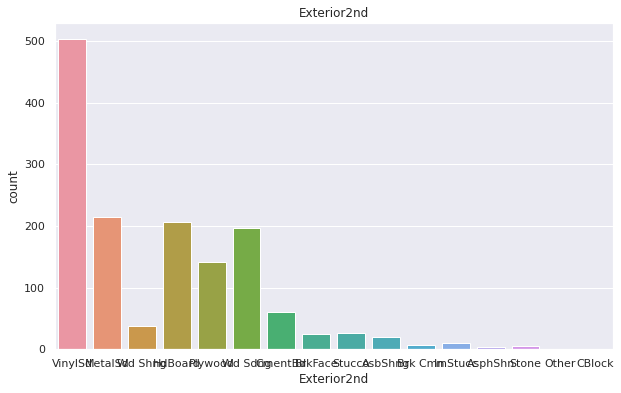

Categories for MasVnrType : 5


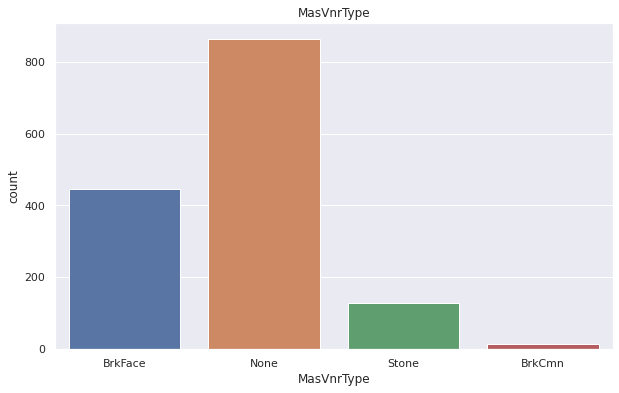

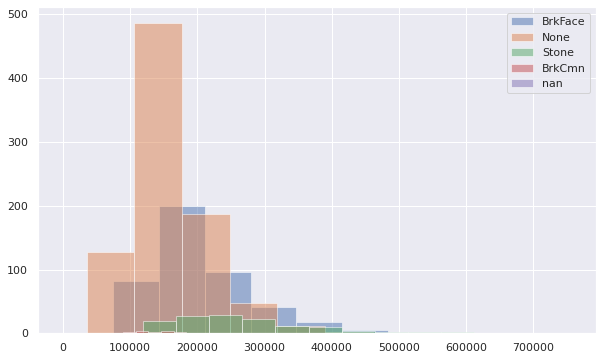

Categories for ExterQual : 4


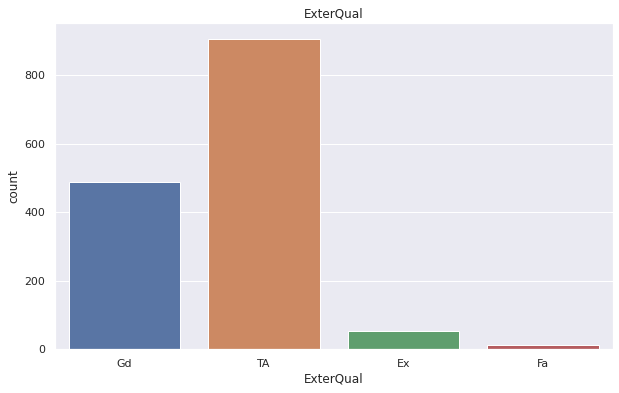

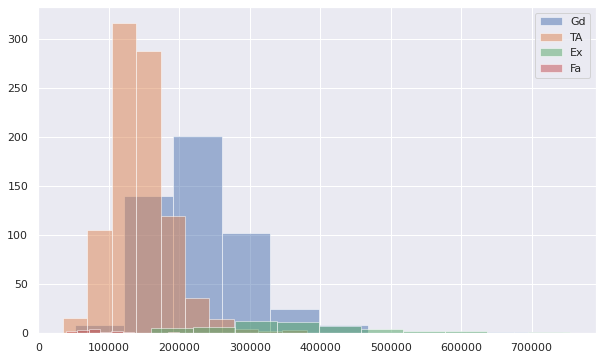

Categories for ExterCond : 5


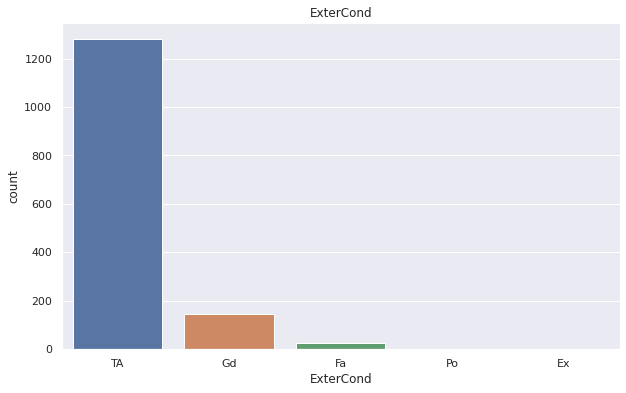

Categories for Foundation : 6


Categories for BsmtQual : 5


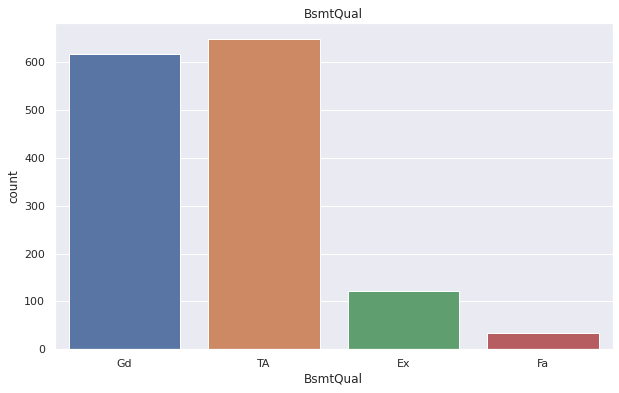

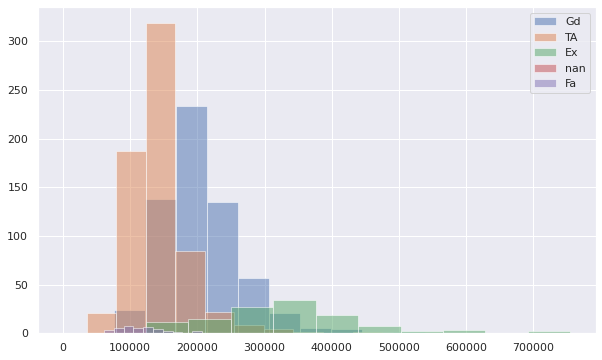

Categories for BsmtCond : 5


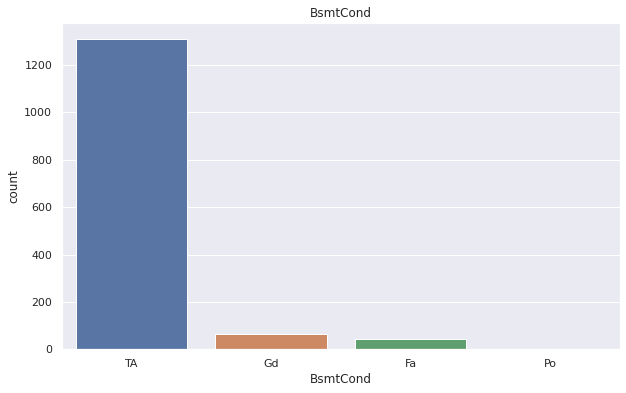

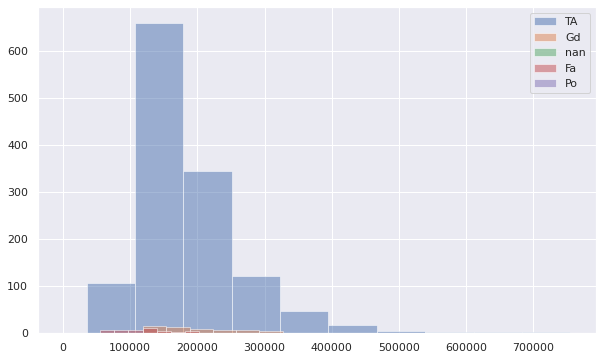

Categories for BsmtExposure : 5


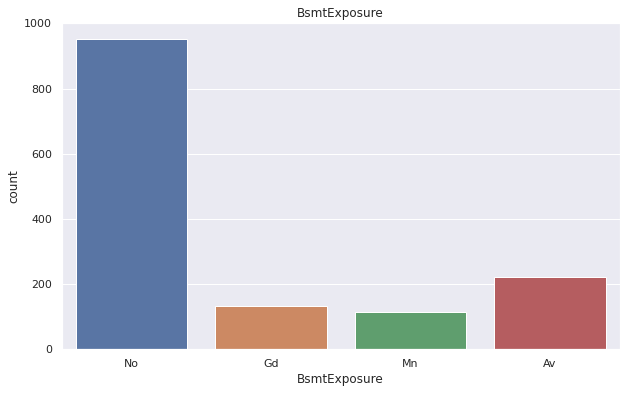

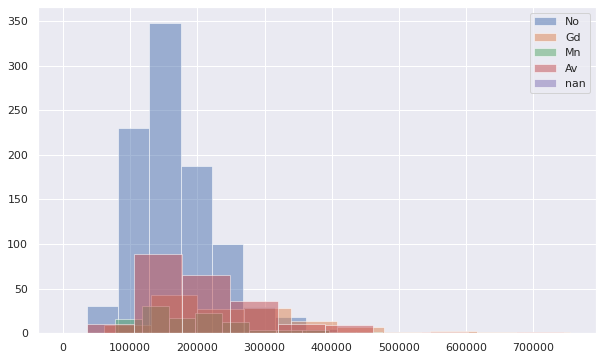

Categories for BsmtFinType1 : 7


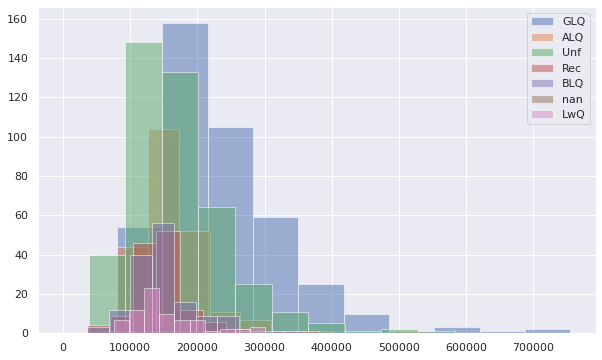

Categories for BsmtFinType2 : 7


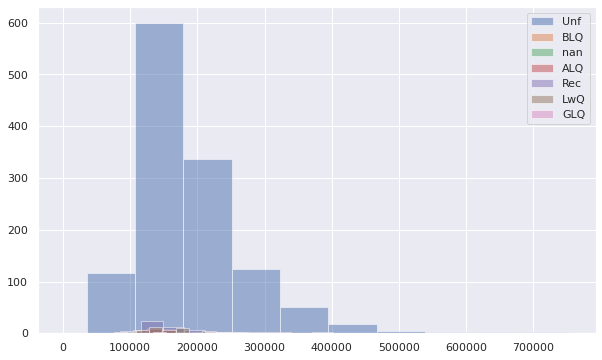

Categories for Heating : 6


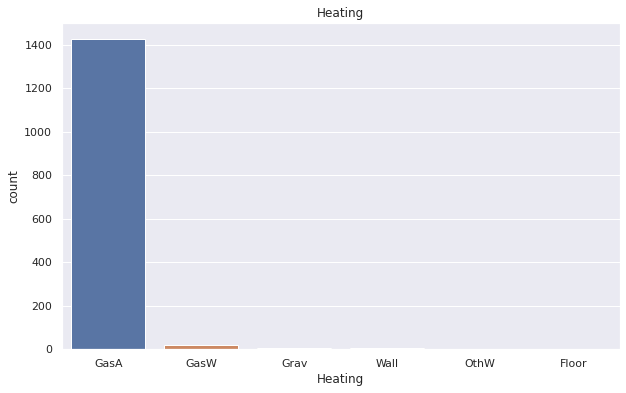

Categories for HeatingQC : 5


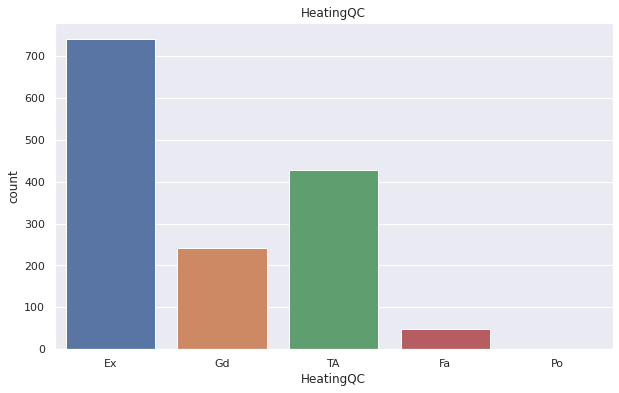

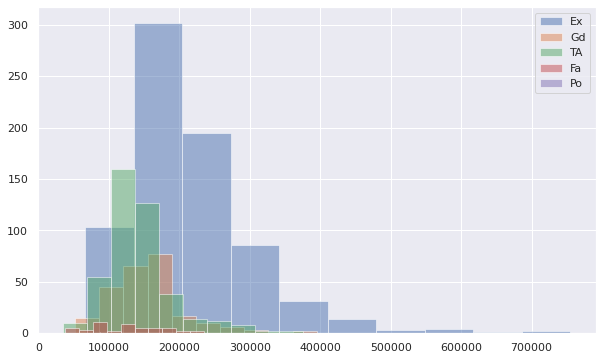

Categories for CentralAir : 2


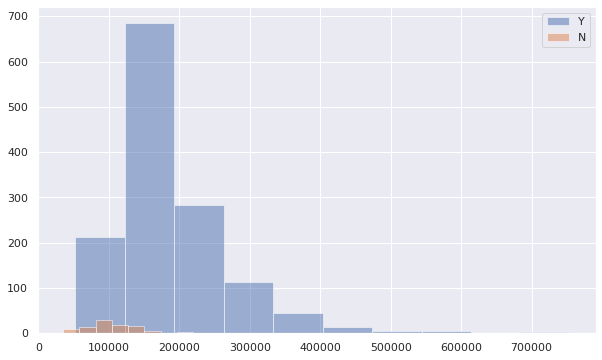

Categories for Electrical : 6


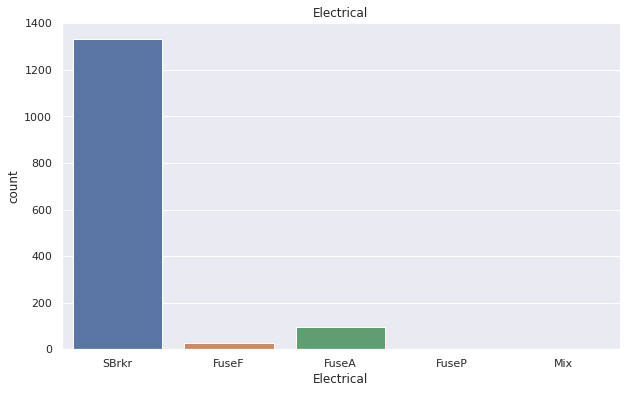

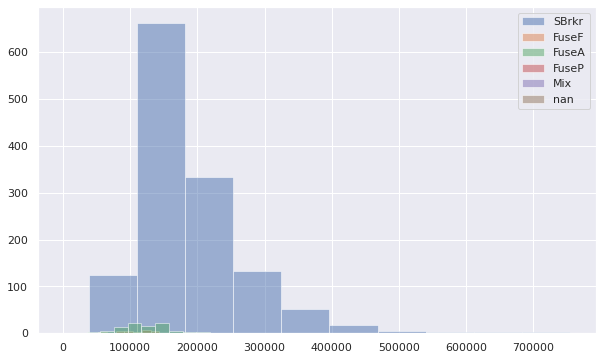

Categories for KitchenQual : 4


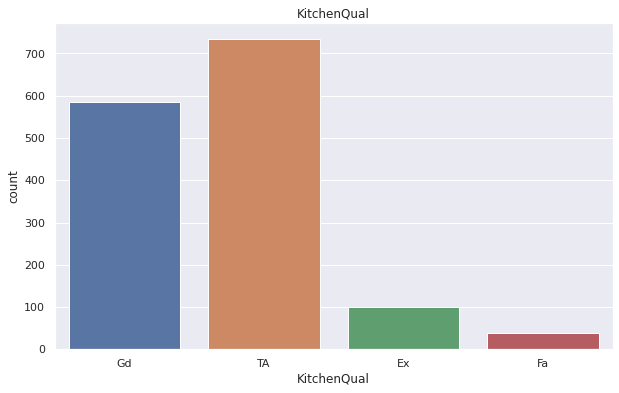

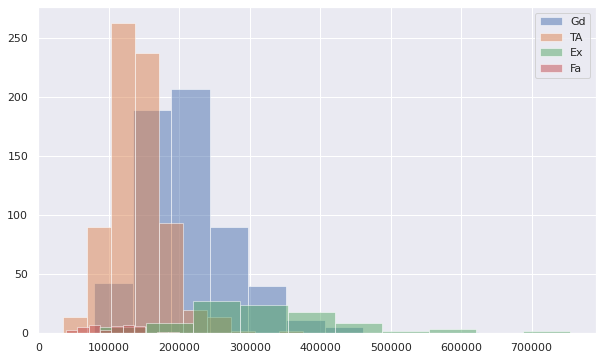

Categories for Functional : 7


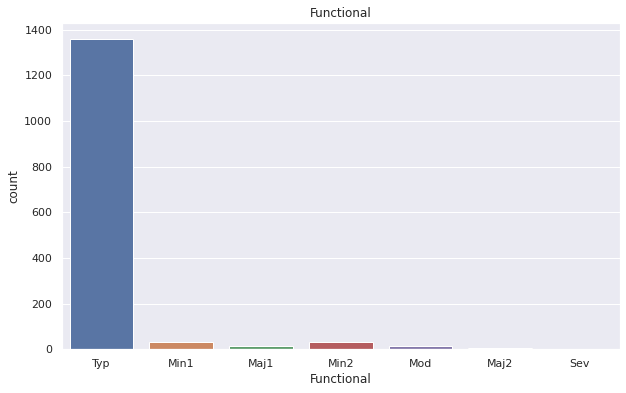

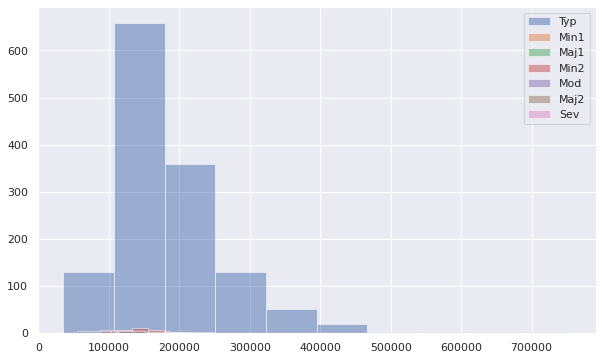

Categories for FireplaceQu : 6


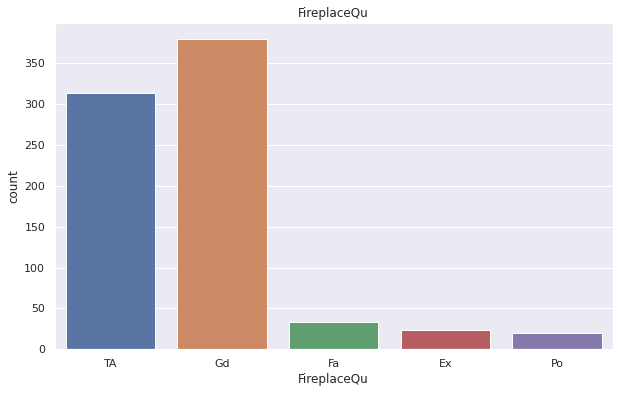

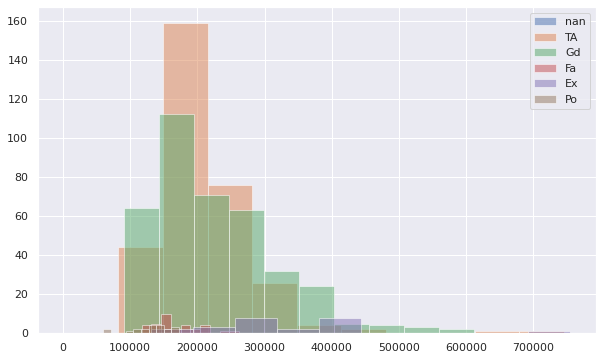

Categories for GarageType : 7


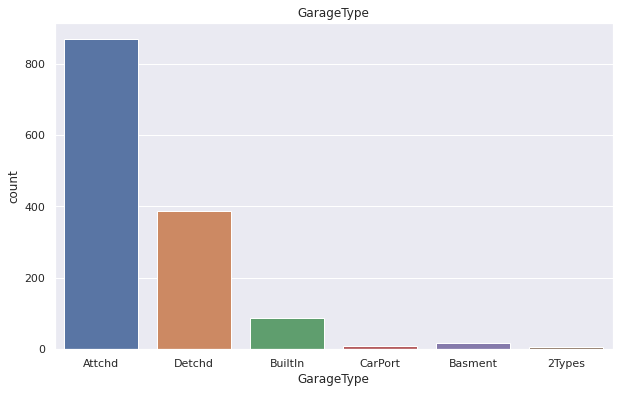

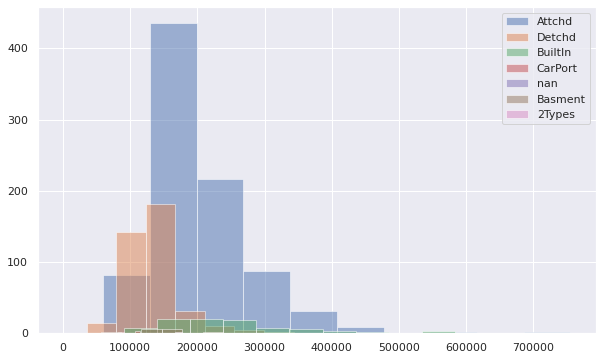

Categories for GarageFinish : 4


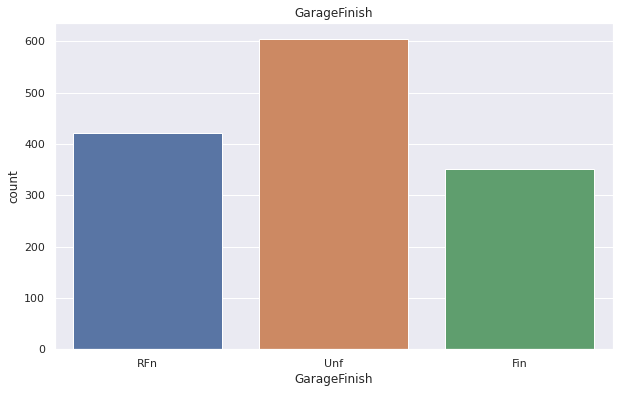

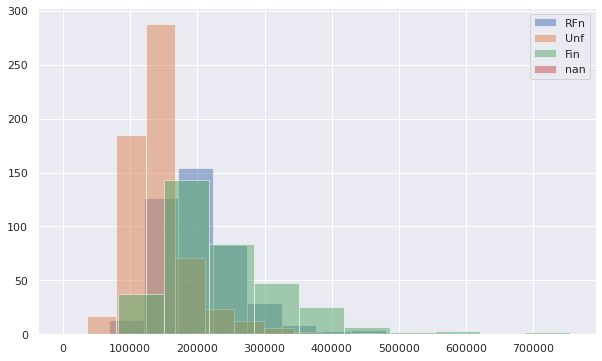

Categories for GarageQual : 6


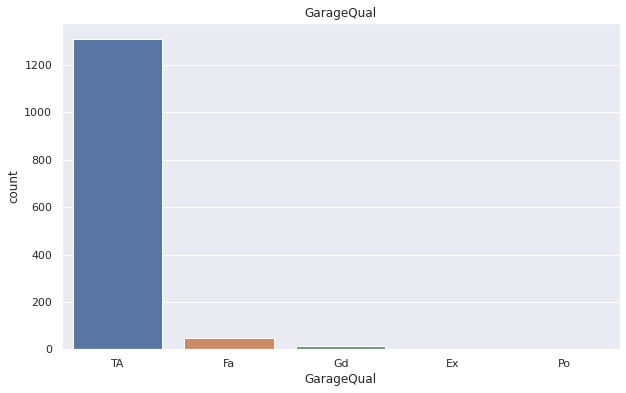

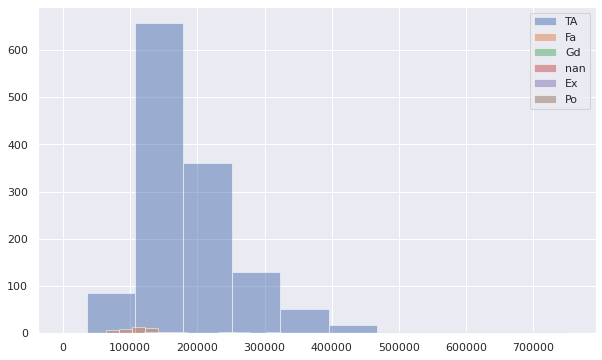

Categories for GarageCond : 6


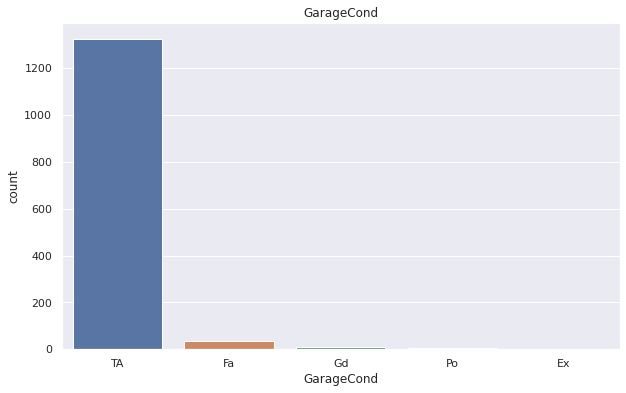

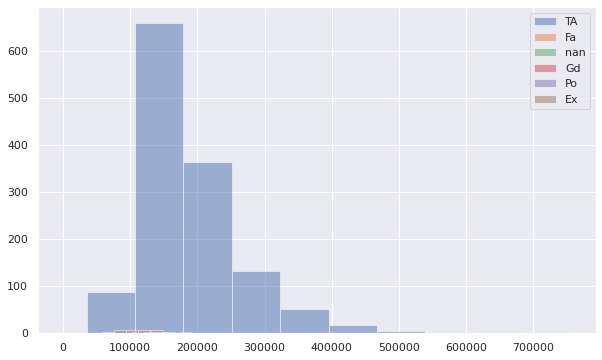

Categories for PavedDrive : 3


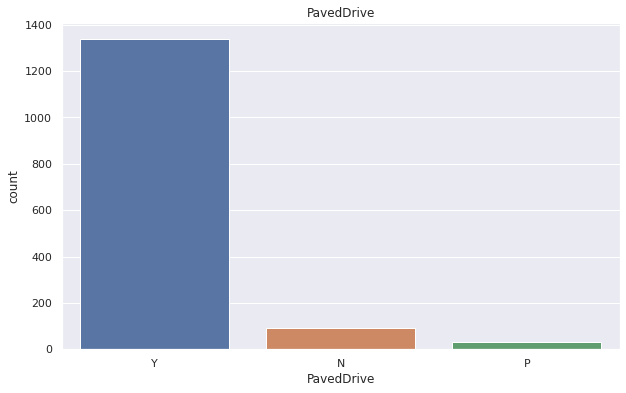

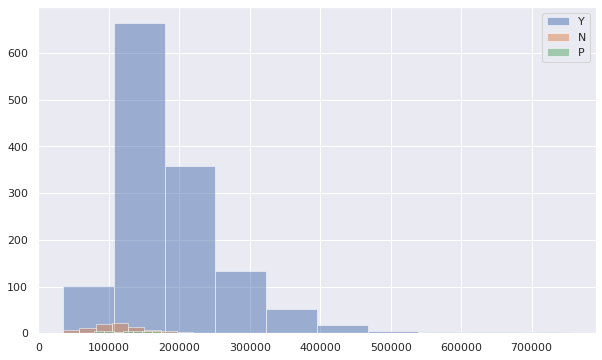

Categories for PoolQC : 4


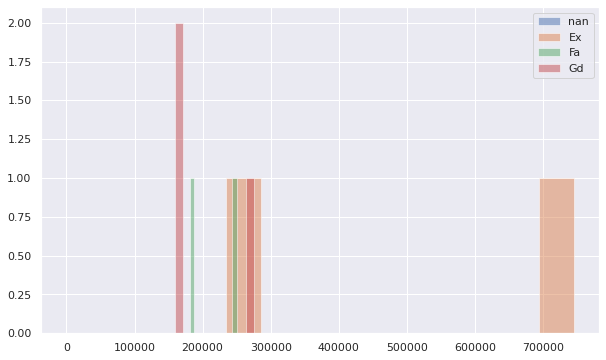

Categories for Fence : 5


Categories for MiscFeature : 5


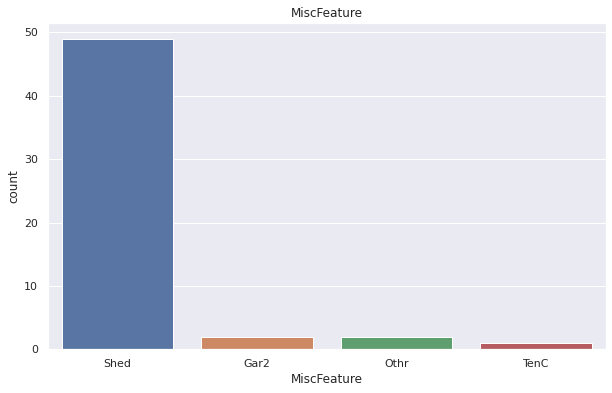

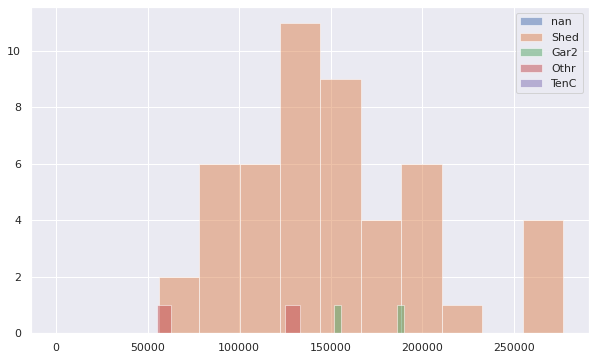

Categories for SaleType : 9


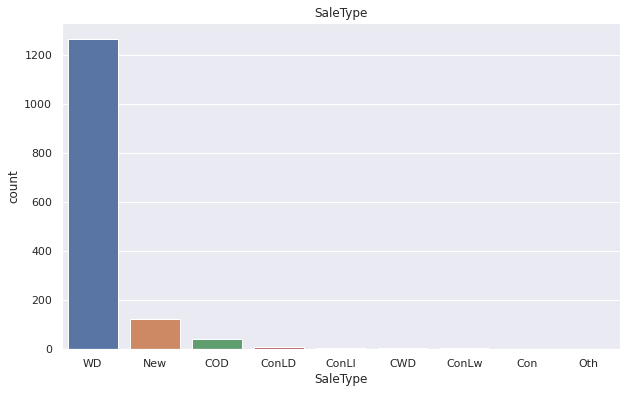

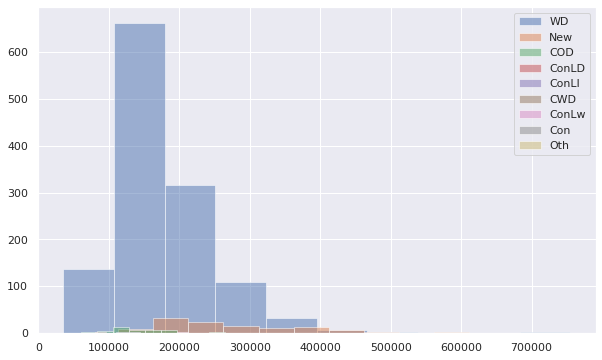

Categories for SaleCondition : 6


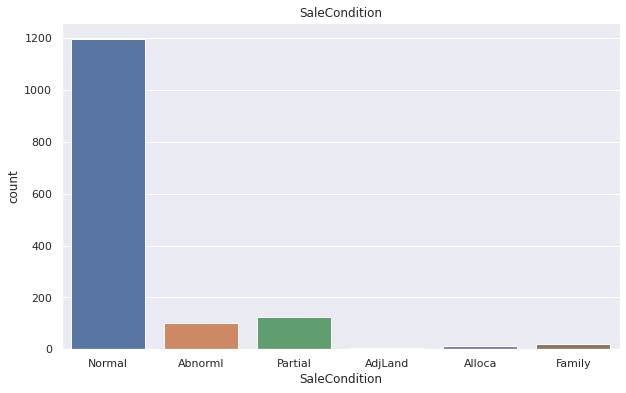

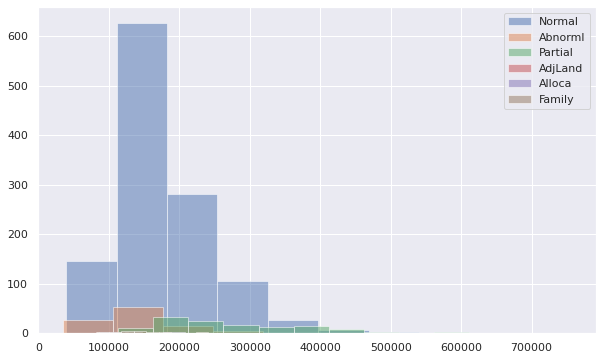

In [20]:
#histograms helps observed the distribution difference within groups
object_train['SalePrice'] = train['SalePrice']
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (10,6)

for i in object_train.columns:
    if i in ['Id','SalePrice']:
        pass
    else:
        categories = object_train[i].unique()
        print('Categories for',i,":",len(categories))
        sns.countplot(x=i,data=object_train)
        plt.title(i)
        plt.show()
        for j in categories:
            plt.hist(object_train[object_train[i] == j]['SalePrice'],alpha=0.5,label=j)
        plt.legend(loc='upper right')
        plt.show()

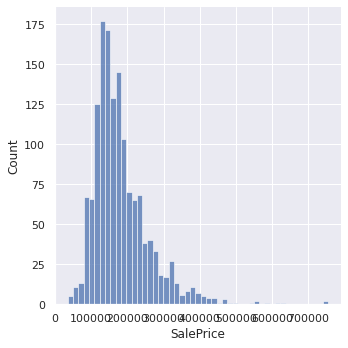

In [21]:
sns.displot(train['SalePrice'])
plt.show()
#SalePrice itself is right-skewed

> 1.4 Observe Time-related features

In [22]:
#Focus on Time related features
def draw_time(data,time_feature,y='SalePrice'):
    frame_mean = data.groupby(time_feature)[y].mean()
    frame_count =  data.groupby(time_feature)[y].count()
    sns.lineplot(x=frame_mean.index,y=frame_mean)
    plt.title('Mean '+y+' Against '+time_feature)
    plt.show()
    sns.lineplot(x=frame_count.index,y=frame_count)
    plt.title('Count '+y+' Against '+time_feature)
    plt.show()

In [23]:
data_all['Sold_time'] = data_all['YrSold'].astype(str)+'/'+data_all['MoSold'].astype(str)
data_all['Sold_time'] = pd.to_datetime(data_all['Sold_time'] , format='%Y/%m')
data_all['MoSold'] = data_all['MoSold'].astype('object')

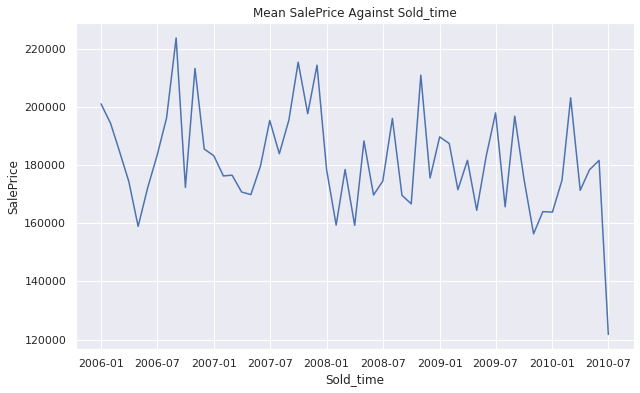

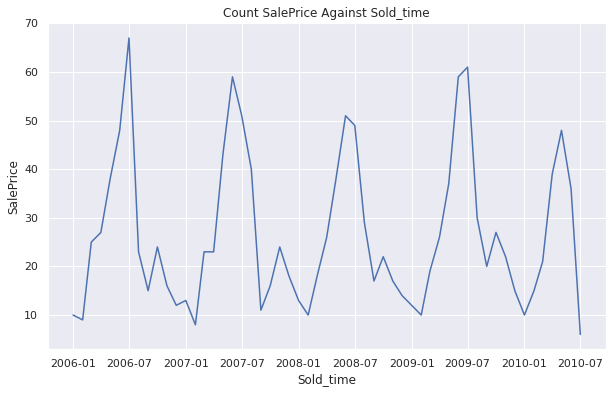

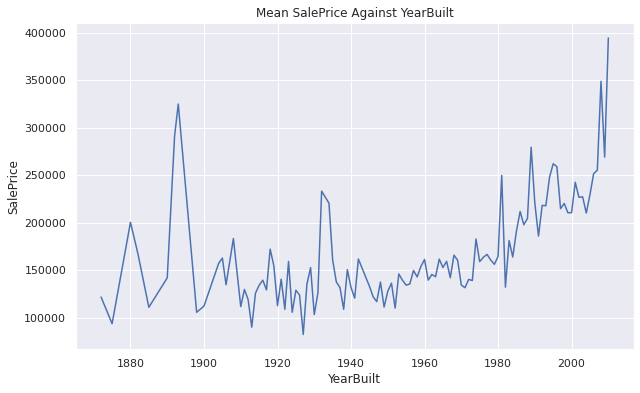

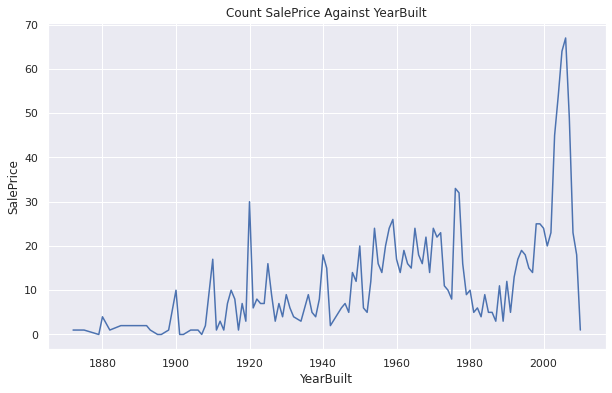

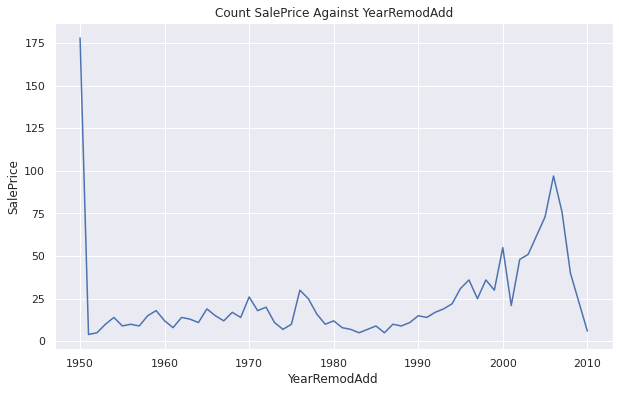

In [24]:
draw_time(data=data_all,time_feature='Sold_time')
draw_time(data=data_all,time_feature='YearBuilt')
draw_time(data=data_all,time_feature='YearRemodAdd')
#seasonality found in sold time and price
#trend found in remodel time and price

> # 2. Feature Engineering

> FEATURE ENGINEERING PROCESS
1. For Categorical('Object')
* Ordinal: change to int and consider scale
* Nominal: Target the high cardinality one's and try to reduce dimension, one hot encoding, 
2. For numerical('int','float')
* Change some 'int' into 'object' if it's actually ordinal or nominal (Shown in EDA)
* Continous: see whether adjust the skewness, standardize
* Interval: normalize
* Time: seasonality, trend
3. Deal with missing value
4. Deal with ourliers
5. Conduct the needed transformation mentioned above

> Feature Selection
* List out the ones that contribute nothing in EDA
* First tryout the ones seem promising
* Deal with multicolinearity or real-world relationship(Domain knowledge needed)

# 2.1 Feature Engineering for Categorical Features

In [25]:
#Change Ordinal features into numbers
data_all['ExterQual'] = data_all['ExterQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
data_all['ExterCond'] = data_all['ExterCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
data_all['BsmtQual'] = data_all['BsmtQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
data_all['BsmtCond'] = data_all['BsmtCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
data_all['BsmtExposure'] = data_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0})
data_all['HeatingQC'] = data_all['HeatingQC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
data_all['KitchenQual'] = data_all['KitchenQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
data_all['FireplaceQu'] = data_all['FireplaceQu'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
data_all['GarageFinish'] = data_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'NA':0})
data_all['GarageQual'] = data_all['GarageQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
data_all['GarageCond'] = data_all['GarageCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
data_all['PavedDrive'] = data_all['PavedDrive'].replace({'Y':3,'P':2,'N':1})
data_all['PoolQC'] = data_all['PoolQC'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1,'NA':0})
data_all['Fence'] = data_all['Fence'].replace({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'NA':0})

In [26]:
#pickout the categrorical features with high cardinality
high_card_col_cat = [i for i in get_cat_features(data_all) if len(data_all[i].unique()) >= 10]
high_card_col_cat.remove('Id')

In [27]:
#build some new features based on our findings in EDA or domain
from scipy import stats
stats.pearsonr(data_all['ExterQual'],data_all['ExterCond'])
#those two are independent variables
#suggest that these two may have interaction effects
data_all['OverallValue'] = data_all['OverallQual'] * data_all['OverallCond']
data_all['ExterValue'] = data_all['ExterQual'] * data_all['ExterCond']
data_all['BsmtQual'] = data_all['BsmtQual'] * data_all['BsmtCond']
data_all['GarageValue'] = data_all['GarageQual'] * data_all['GarageCond']
data_all['TotalArea'] = data_all['TotalBsmtSF'] + data_all['1stFlrSF'] + data_all['2ndFlrSF']

In [28]:
print(data_all.groupby('MSSubClass')['SalePrice'].mean())
print(data_all.groupby('Exterior1st')['SalePrice'].mean())
print(data_all.groupby('Exterior2nd')['SalePrice'].mean())
MSSubClass_Stories = {'20':1,'30':1,'40':1,'45':1.5,'50':1.5,'60':2,'70':2,'75':2.5,'120':1,'150':1.5,'160':2}
MSSubClass_Ages = {'20':1,'30':0,'40':0.5,'45':0.5,'50':0.5,'60':1,'70':0,'75':0.5,'90':0.5,'120':1,'150':0.5,'160':1}
MSSubClass_Other = []
def get_MSSubClass_Stories(data):
    if str(data) in MSSubClass_Stories.keys():
        return MSSubClass_Stories[str(data)]
    else:
        return 2
def get_MSSubClass_Ages(data):
    if str(data) in MSSubClass_Ages.keys():
        return MSSubClass_Ages[str(data)]
    else:
        return 0.5


data_all['Stories'] = data_all['MSSubClass'].apply(get_MSSubClass_Stories)
data_all['Ages'] = data_all['MSSubClass'].apply(get_MSSubClass_Ages)


MSSubClass
20     185224.811567
30      95829.724638
40     156125.000000
45     108591.666667
50     143302.972222
60     239948.501672
70     166772.416667
75     192437.500000
80     169736.551724
85     147810.000000
90     133541.076923
120    200779.080460
150              NaN
160    138647.380952
180    102300.000000
190    129613.333333
Name: SalePrice, dtype: float64
Exterior1st
AsbShng    107385.550000
AsphShn    100000.000000
BrkComm     71000.000000
BrkFace    194573.000000
CBlock     105000.000000
CemntBd    231690.655738
HdBoard    163077.450450
ImStucc    262000.000000
MetalSd    149422.177273
Plywood    175942.379630
Stone      258500.000000
Stucco     162990.000000
VinylSd    213732.900971
Wd Sdng    149841.645631
WdShing    150655.076923
Name: SalePrice, dtype: float64
Exterior2nd
AsbShng    114060.550000
AsphShn    138000.000000
Brk Cmn    126714.285714
BrkFace    195818.000000
CBlock     105000.000000
CmentBd    230093.833333
HdBoard    167661.565217
ImStucc    2520

In [29]:
#Use data from outside, outside data can often help making decision if possible
#this part is inspired by Mustafa Cicek, check out his amazing notebook as well:)

geo = {"North":["Blmngtn", "BrDale", "ClearCr", "Gilbert",  "Names", "NoRidge", "NPkVill", 
           "NoRidge", "NridgHt", "Sawyer", "Somerst", "StoneBr", "Veenker", "NridgHt"],

"South":["Blueste", "Edwards", "Mitchel", "MeadowV", "SWISU", "IDOTRR", "Timber"],
"Downtown":["BrkSide", "Crawfor", "OldTown", "CollgCr"],
"West":["Edwards", "NWAmes", "SWISU", "SawyerW"]}
def find_geo(neighborhood):
    for key, value in geo.items():
        if neighborhood in value:
            return key
        else:
            pass
    return np.nan
data_all['Geo'] = data_all['Neighborhood'].apply(find_geo)
print(data_all.groupby('Geo')['SalePrice'].mean())

Geo
Downtown    167114.411290
North       227755.015119
South       145167.063433
West        187935.204545
Name: SalePrice, dtype: float64


# 2.2 Feature Engineering for Numerical Data

In [30]:
#fix skew for x
from scipy.stats import skew
skewed_feats = data_all[get_num_features(data_all)].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew_col = skewed_feats[abs(skewed_feats) > 0.5].index

In [31]:
for i in high_skew_col:
    data_all[i] = np.log1p(data_all[i])

# 2.3 Missing Values

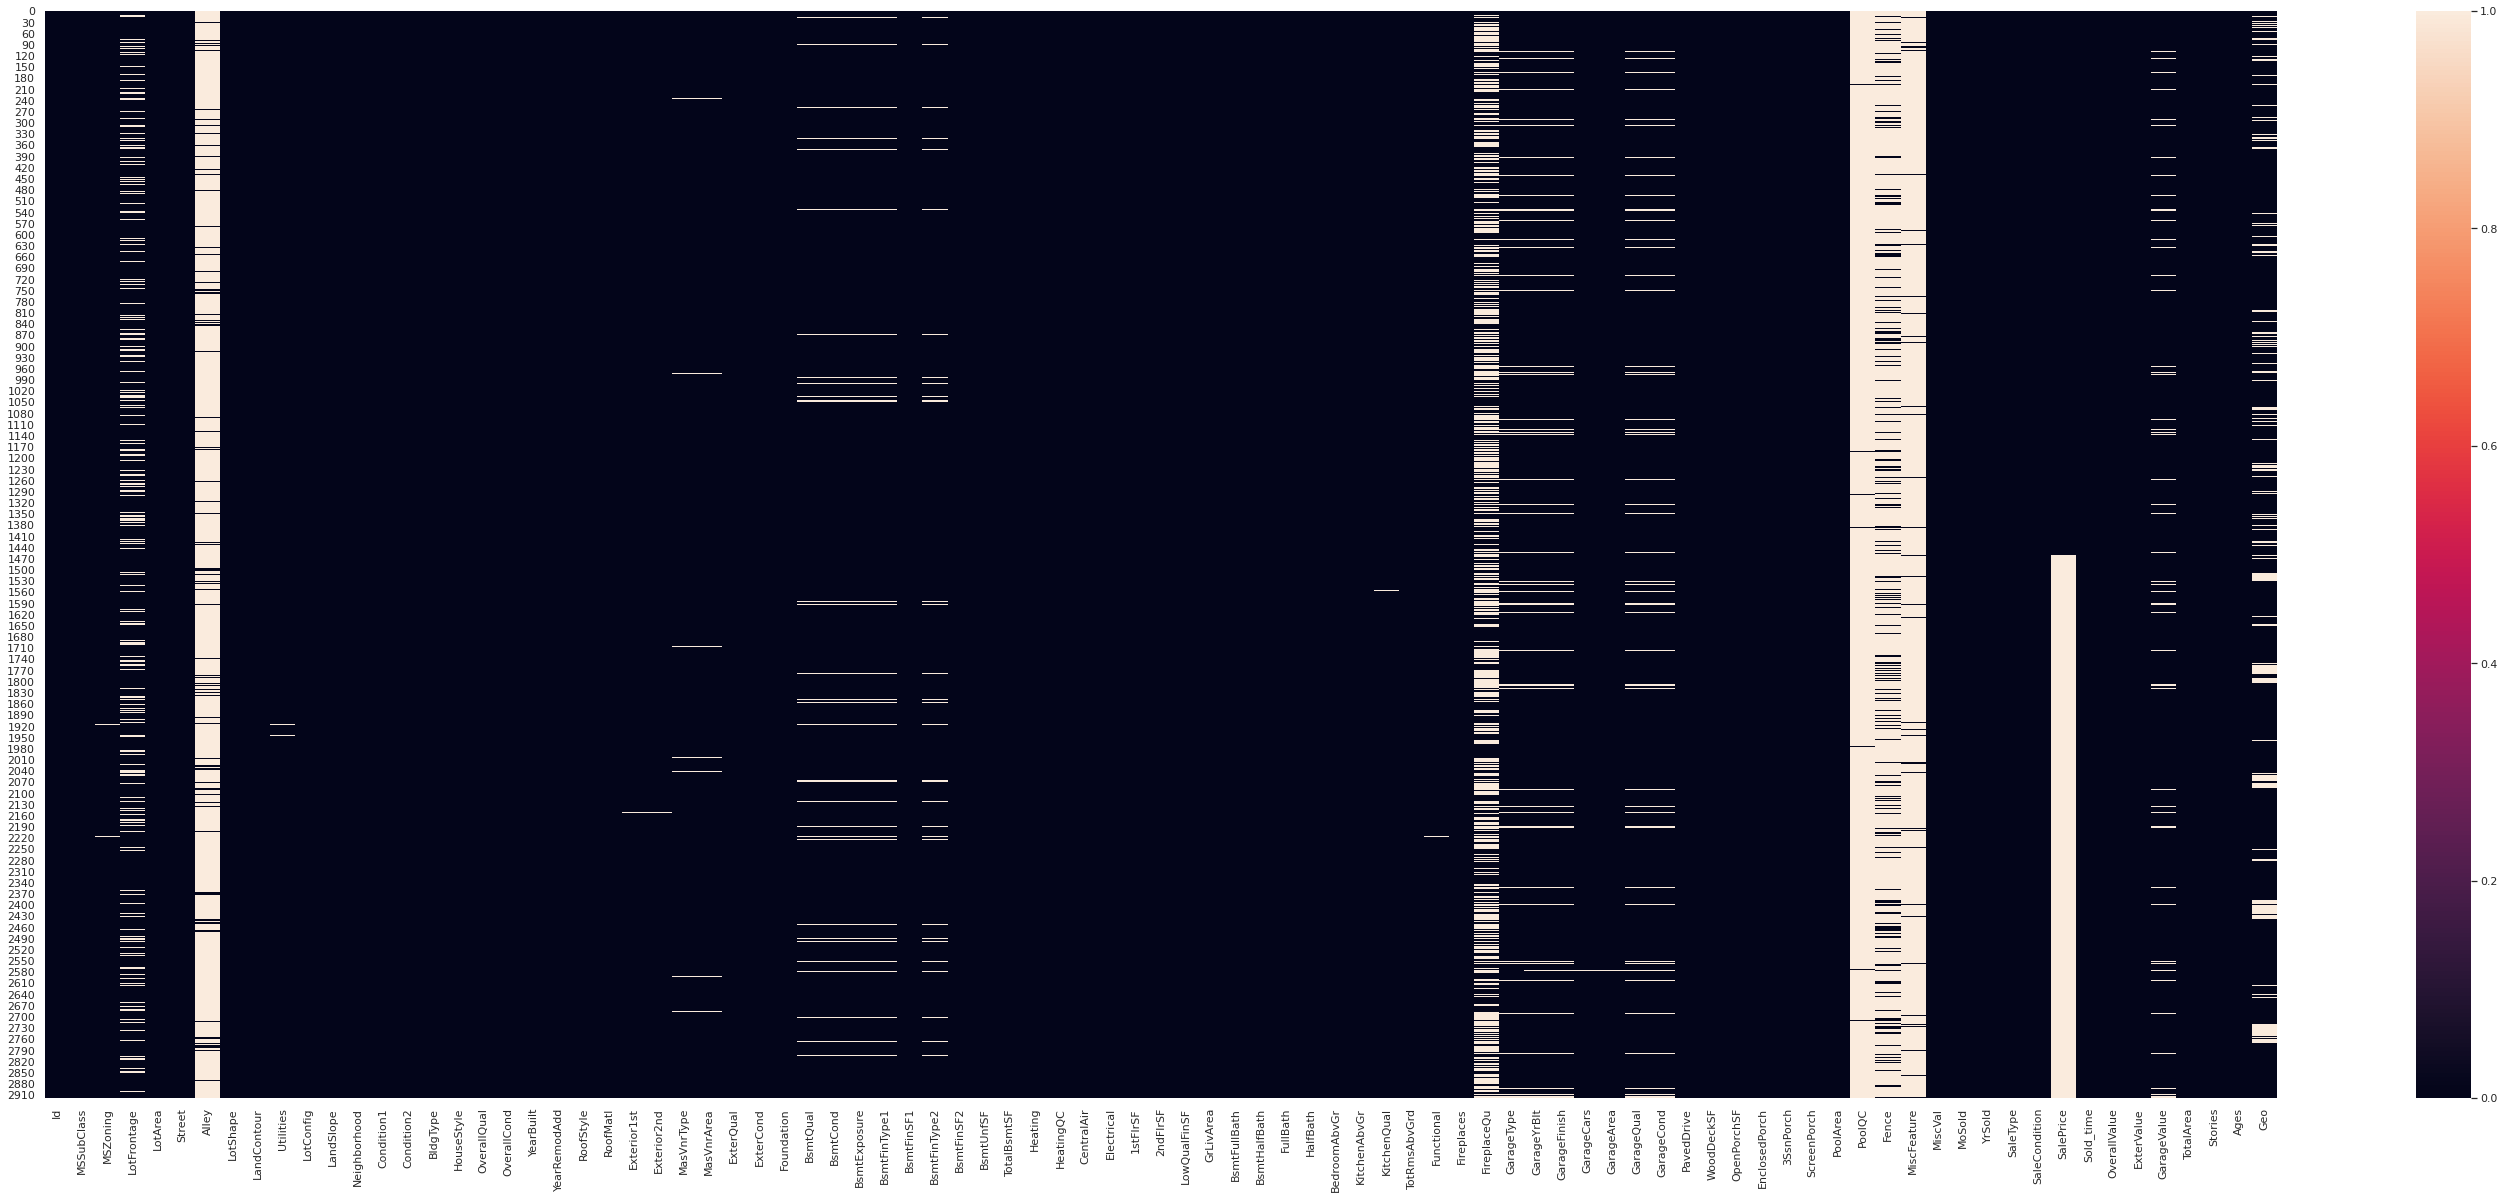

In [32]:
###Missing Values
missing_counts = pd.DataFrame(data_all.isnull().sum().sort_values(ascending=False))
plt.figure(figsize=(50,20))
sns.heatmap(data_all.isnull())
plt.show()
plt.figure(figsize=(20,10))
missing_columns = missing_counts[missing_counts.iloc[:,0]>0]
sns.barplot(x=missing_columns.index,y=missing_columns.iloc[:,0])
plt.xticks(rotation=90)
plt.show()

In [33]:
#delete features with more than 1000 missing values
drop_col = list(missing_counts[missing_counts.iloc[:,0] > 1000].index)
drop_col.remove('SalePrice')
missing_columns = missing_columns.drop(index='SalePrice')
try:
    data_all = data_all.drop(columns=drop_col,axis=0)
    missing_columns = missing_columns.drop(index=drop_col,axis=1)
except:
    pass

In [34]:
print(data_all[missing_columns.index].info())
#Since some numerical features are ordinal ones
#it would be more reasonable to use median as the default values
#as for categorical ones, we opt for the mode category
missing_object = data_all[missing_columns.index].select_dtypes('object').columns
print('missing object',len(missing_object))
missing_num = data_all[missing_columns.index].select_dtypes(['int64','float64']).columns
print('missing num ',len(missing_num))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   2433 non-null   float64
 1   Geo           2476 non-null   object 
 2   GarageValue   2760 non-null   float64
 3   GarageYrBlt   2760 non-null   float64
 4   GarageFinish  2760 non-null   float64
 5   GarageCond    2760 non-null   float64
 6   GarageQual    2760 non-null   float64
 7   GarageType    2762 non-null   object 
 8   BsmtQual      2835 non-null   float64
 9   BsmtExposure  2837 non-null   float64
 10  BsmtCond      2837 non-null   float64
 11  BsmtFinType2  2839 non-null   object 
 12  BsmtFinType1  2840 non-null   object 
 13  MasVnrType    2895 non-null   object 
 14  MasVnrArea    2896 non-null   float64
 15  MSZoning      2915 non-null   object 
 16  BsmtFullBath  2917 non-null   float64
 17  BsmtHalfBath  2917 non-null   float64
 18  Utilities     2917 non-null 

In [35]:
for i in missing_num:
    data_all[i] = data_all[i].fillna(data_all[i].median())
for j in missing_object:
    data_all[j] = data_all[j].fillna(data_all[j].mode()[0])
print(data_all.isnull().any().sum())
#1 missing is SalesPrice

1


# 2.4 Extreme Values

In [36]:
###Extreme Values
#here we only look at the important features discovered in EDA
print(data_all[important_features_CC].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   2919 non-null   int64  
 1   GrLivArea     2919 non-null   float64
 2   GarageCars    2919 non-null   float64
 3   GarageArea    2919 non-null   float64
 4   TotalBsmtSF   2919 non-null   float64
 5   1stFlrSF      2919 non-null   float64
 6   FullBath      2919 non-null   int64  
 7   TotRmsAbvGrd  2919 non-null   float64
 8   YearBuilt     2919 non-null   float64
 9   YearRemodAdd  2919 non-null   int64  
dtypes: float64(7), int64(3)
memory usage: 228.2 KB
None


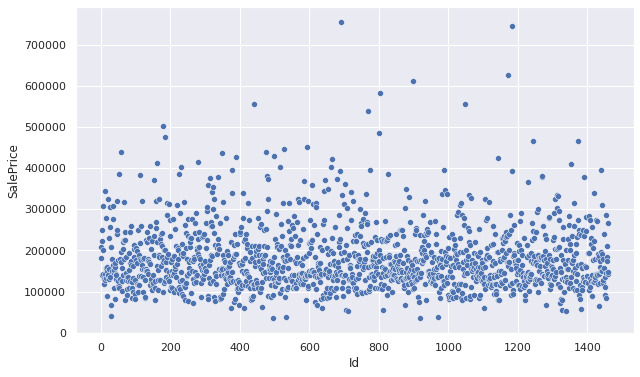

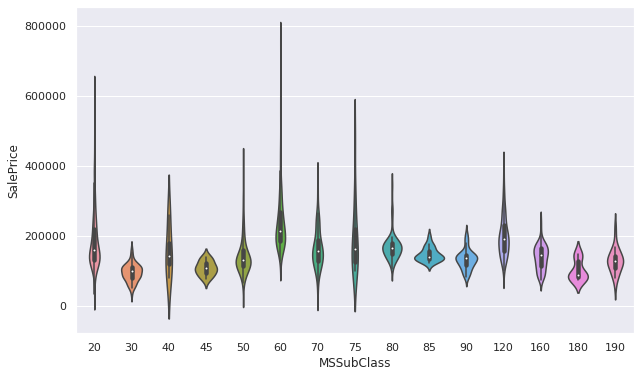

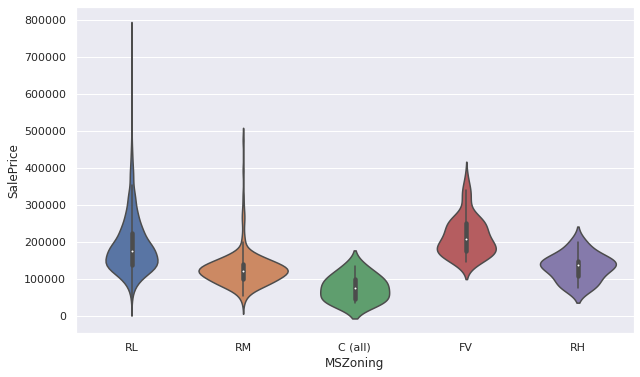

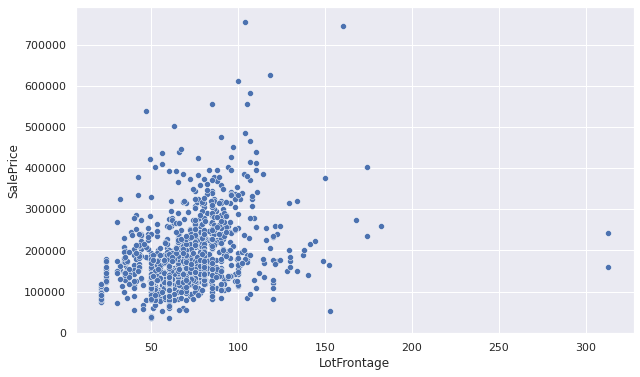

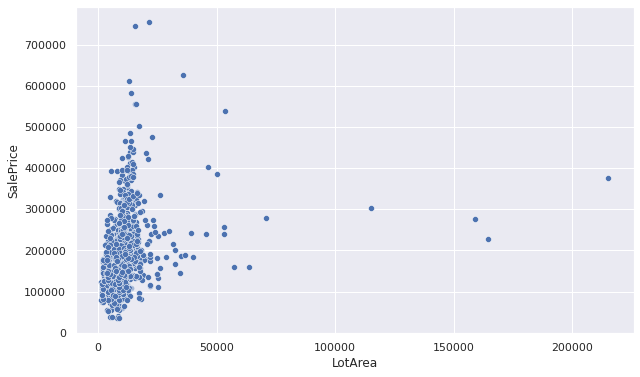

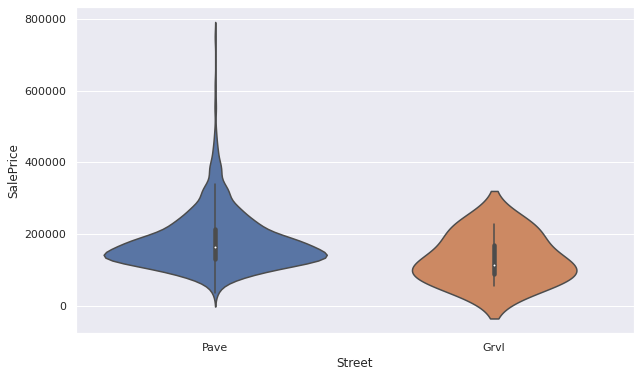

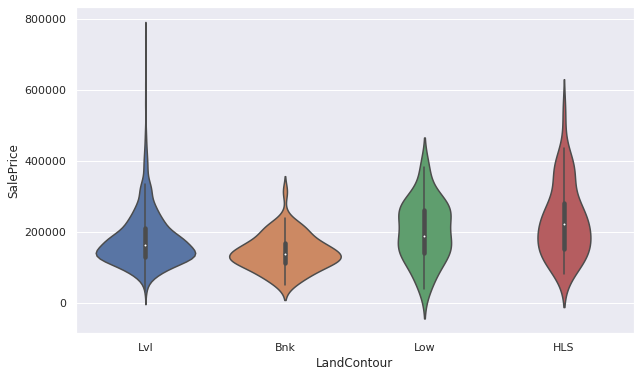

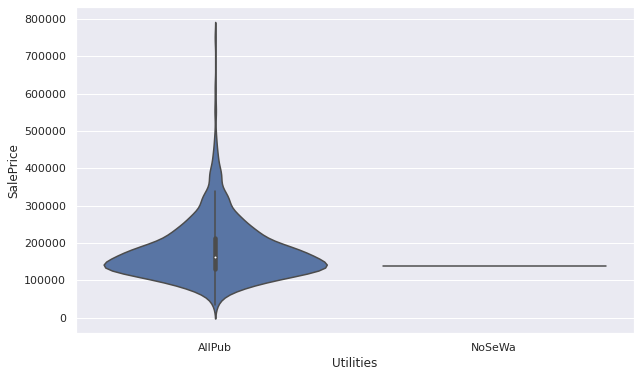

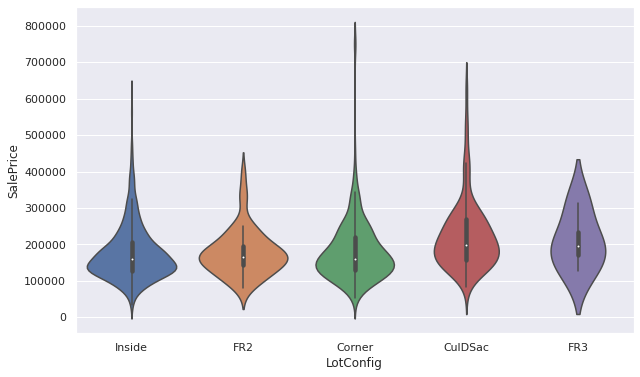

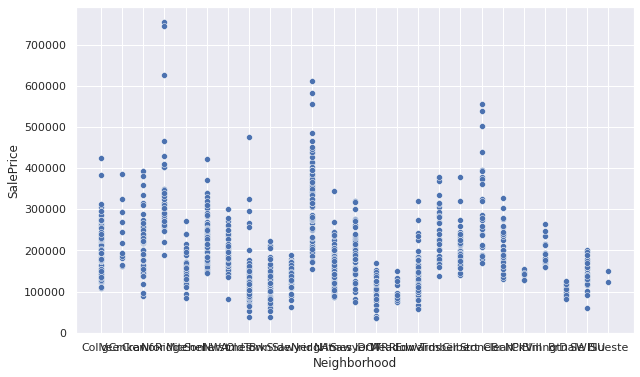

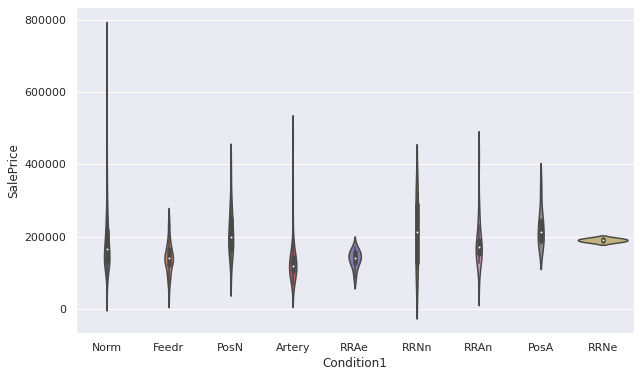

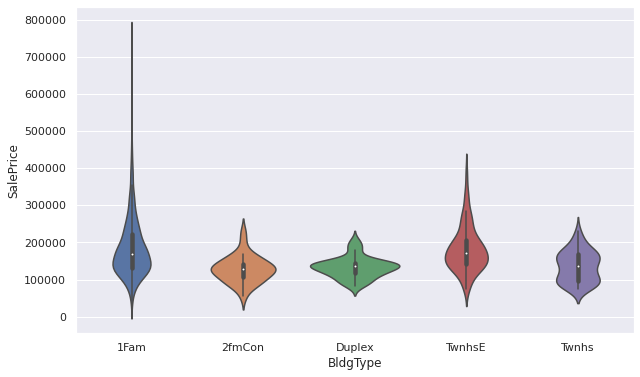

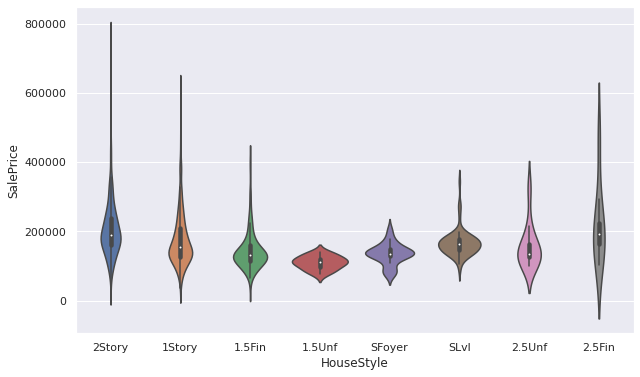

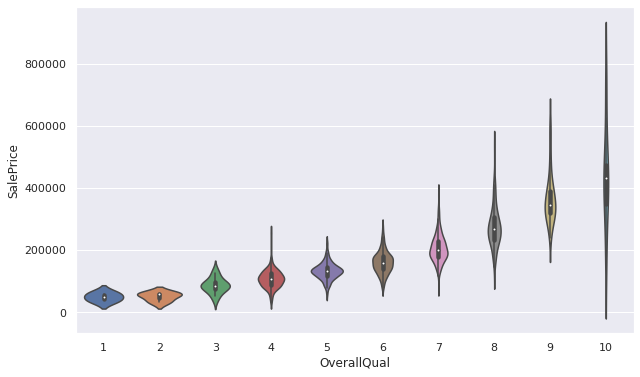

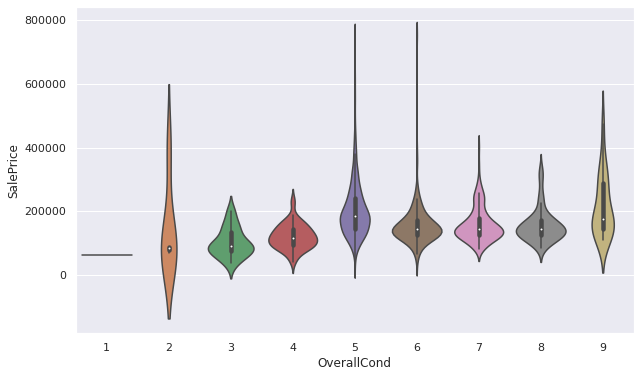

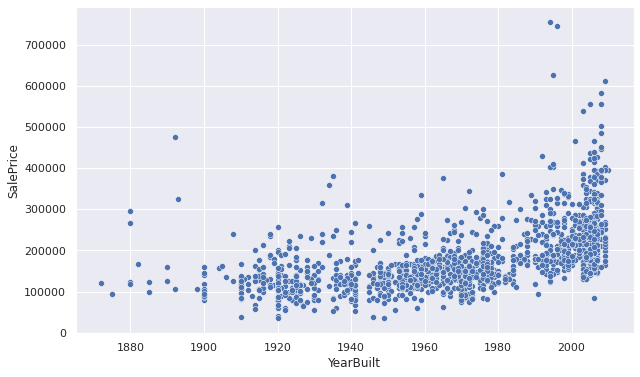

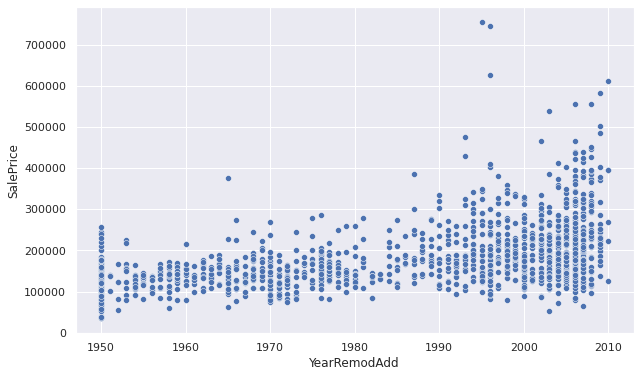

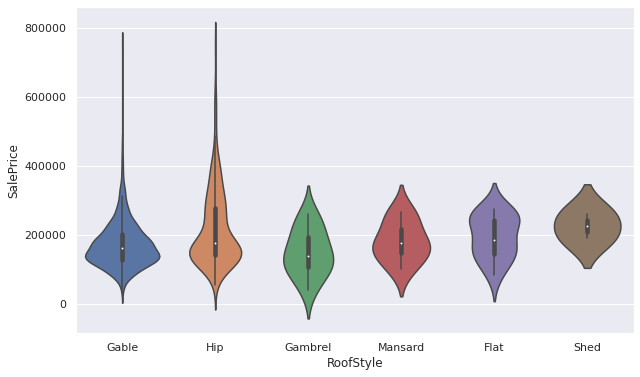

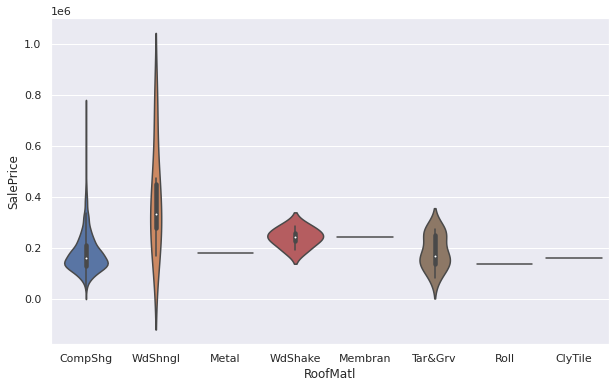

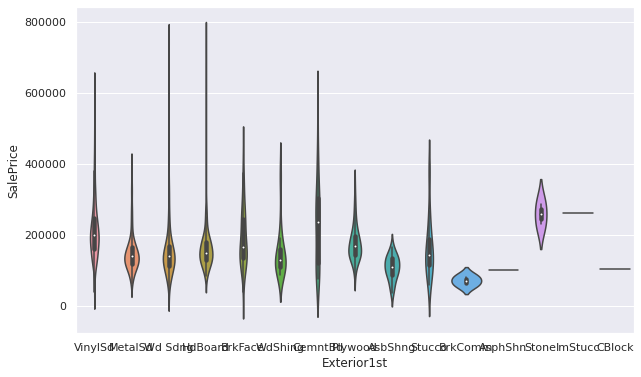

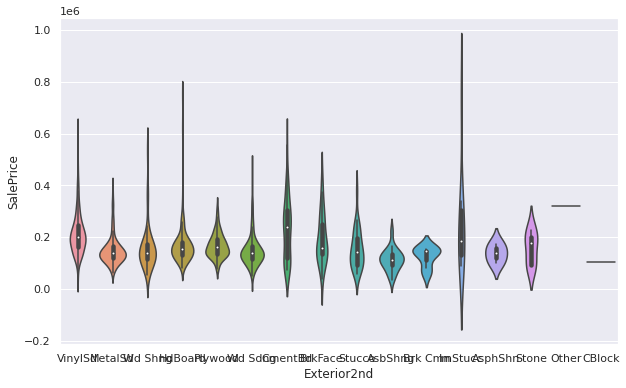

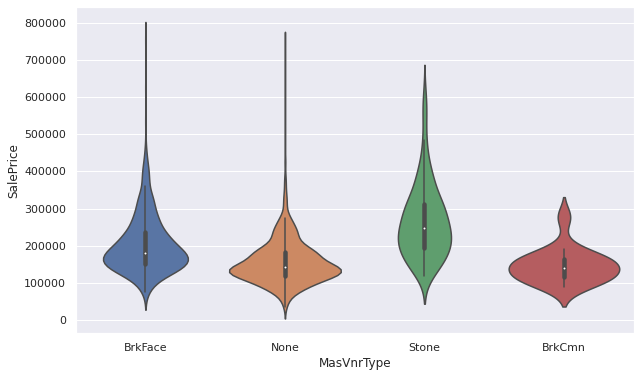

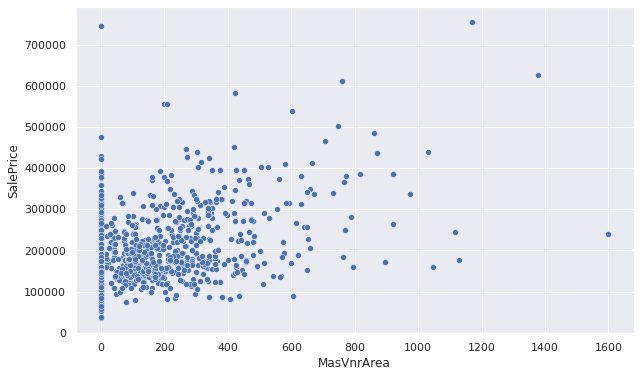

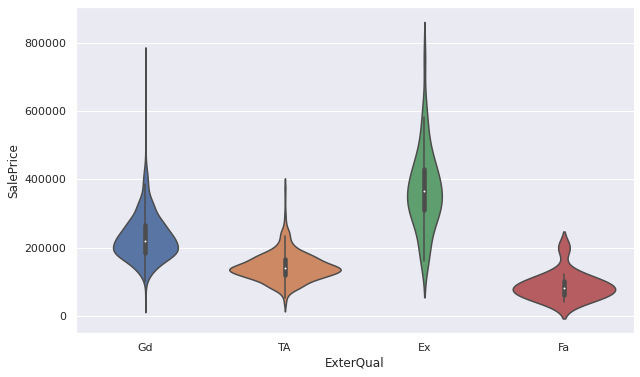

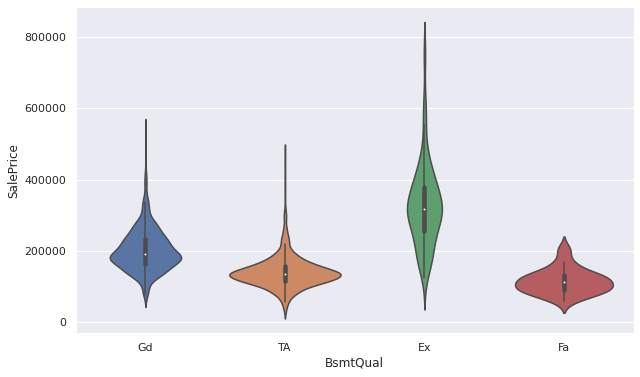

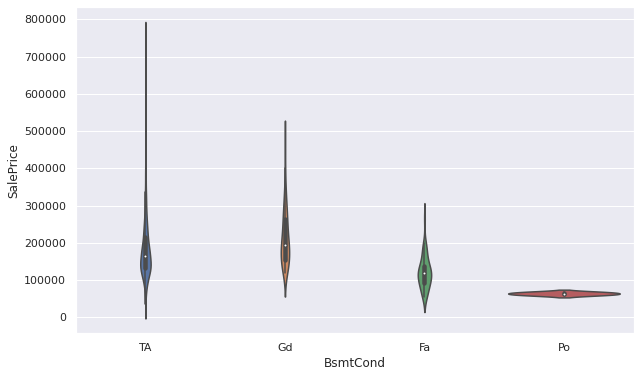

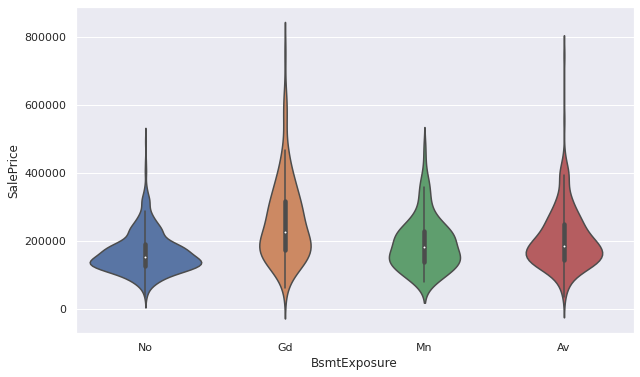

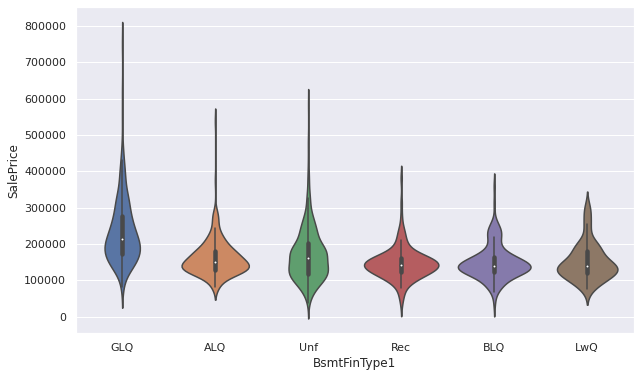

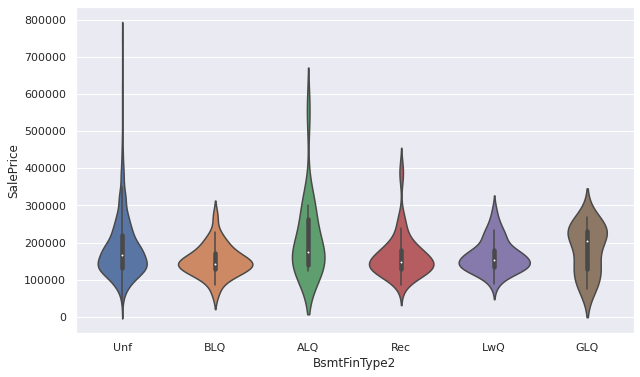

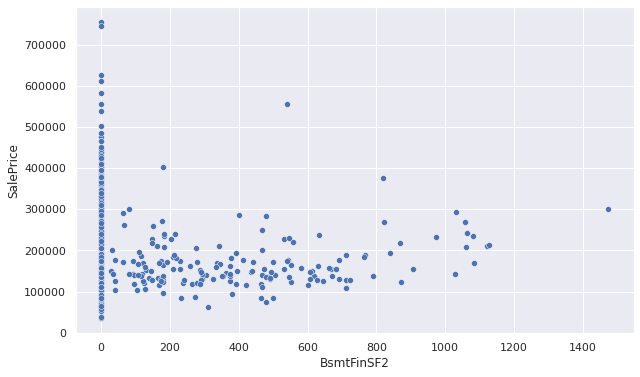

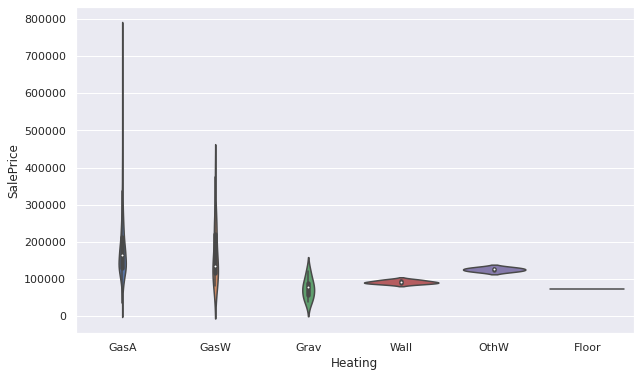

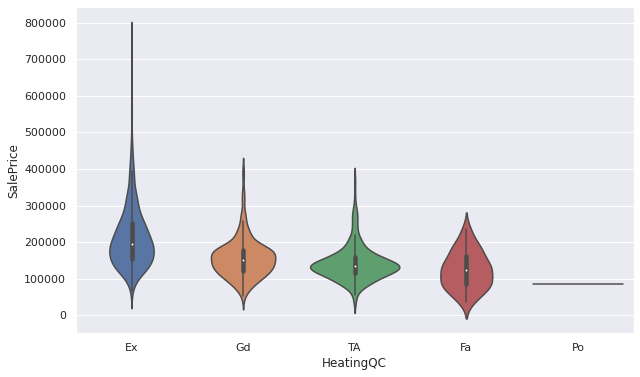

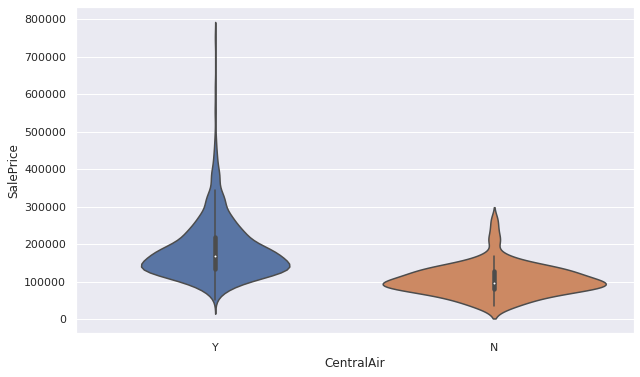

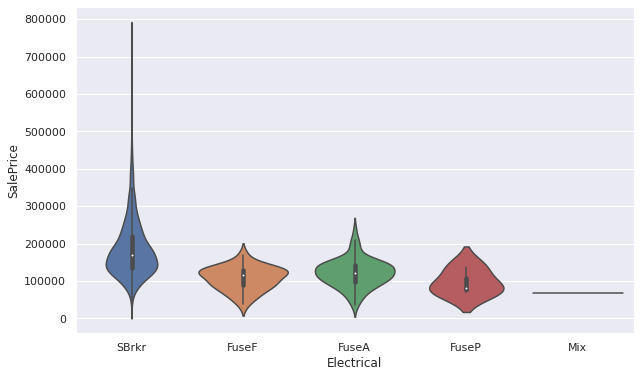

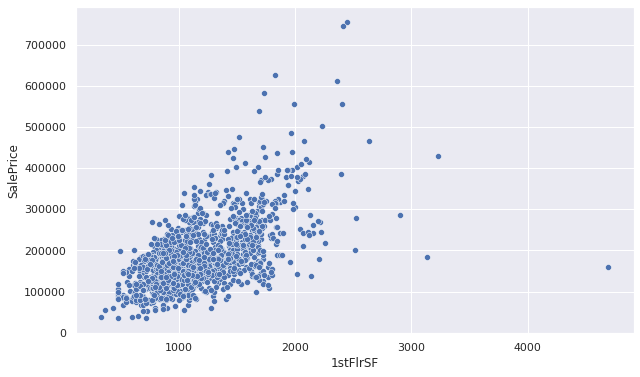

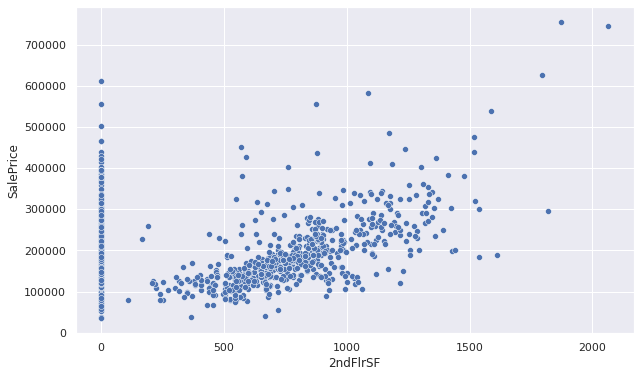

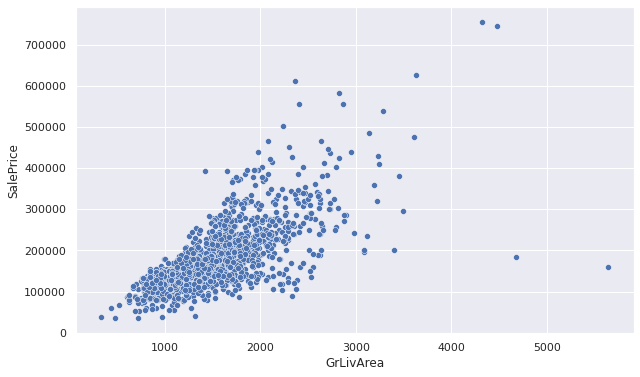

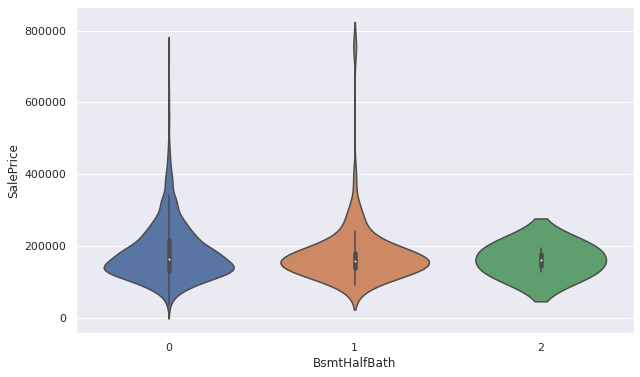

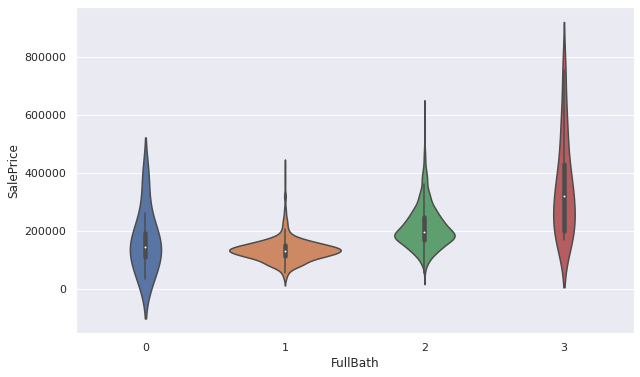

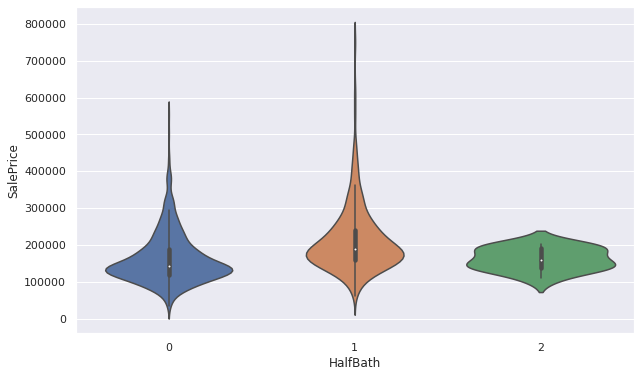

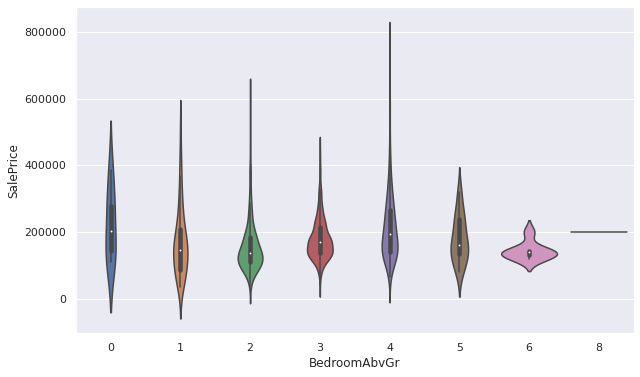

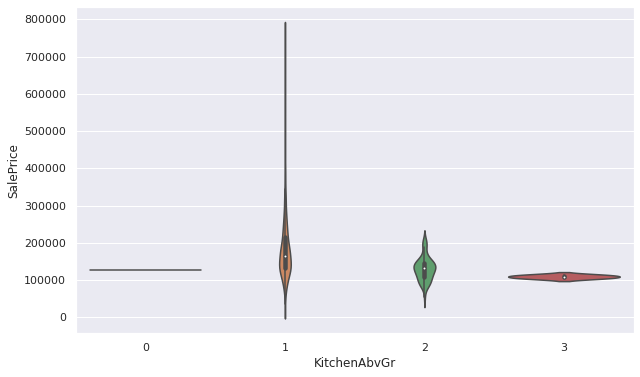

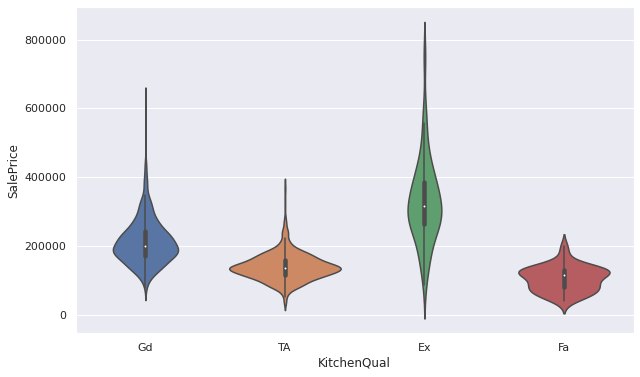

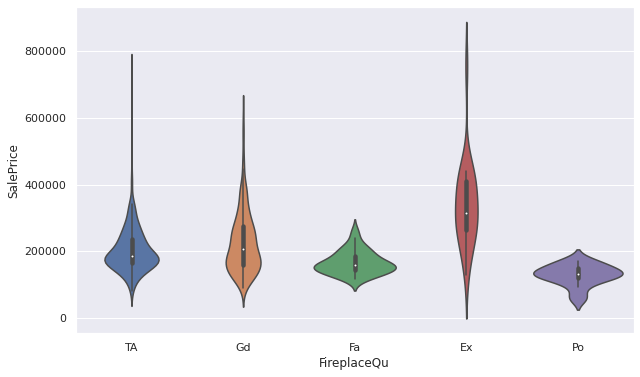

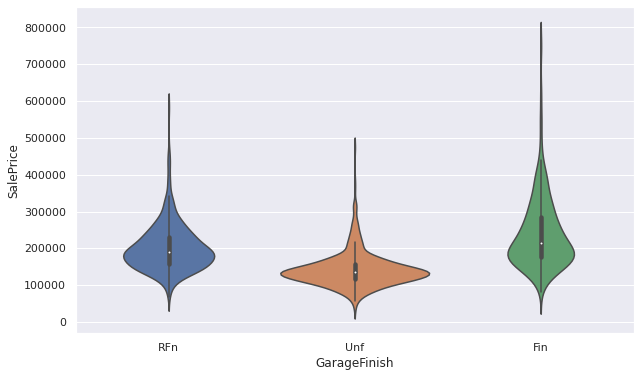

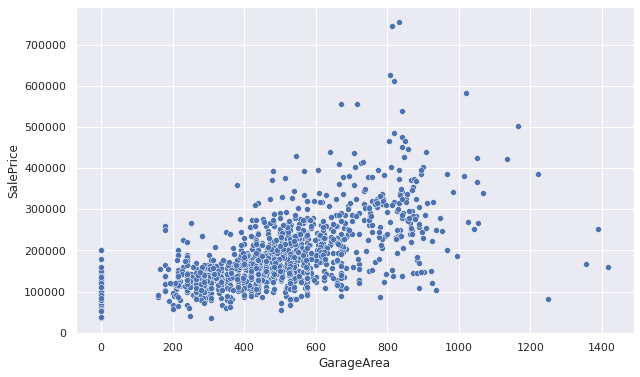

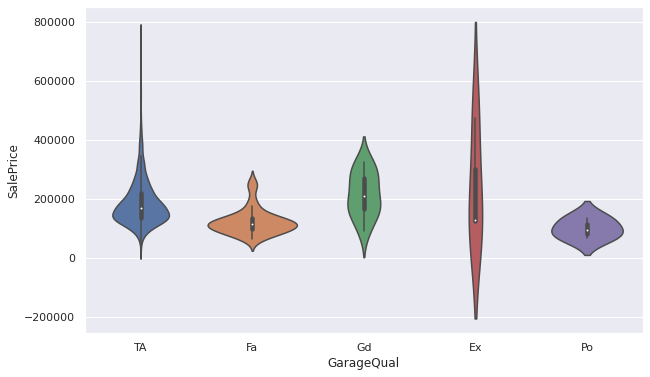

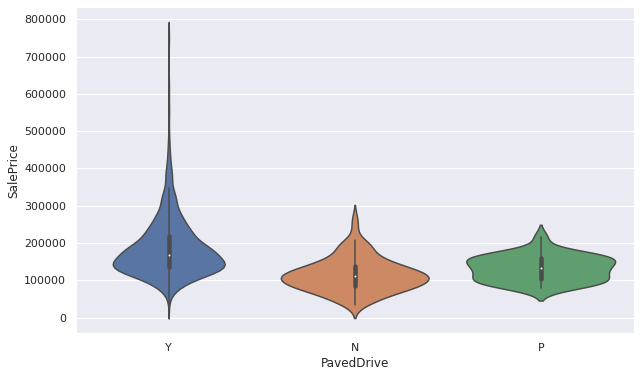

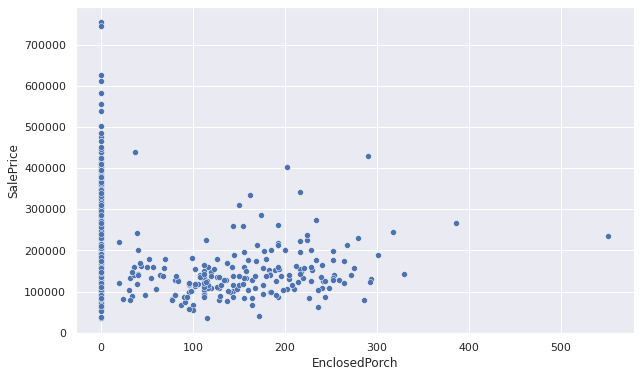

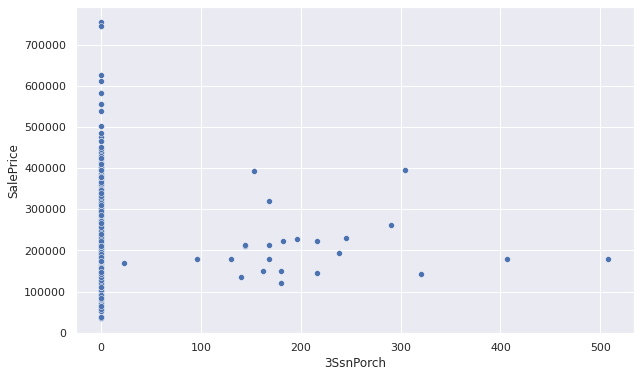

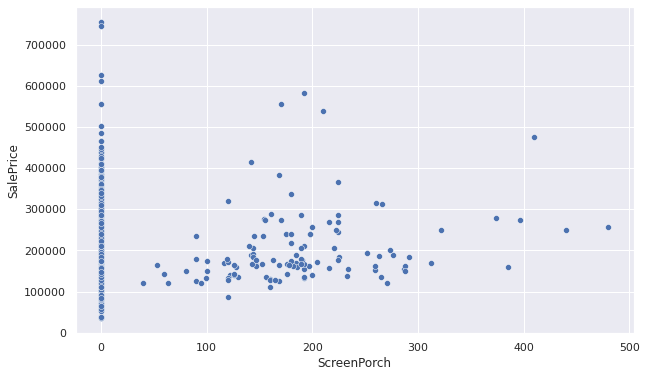

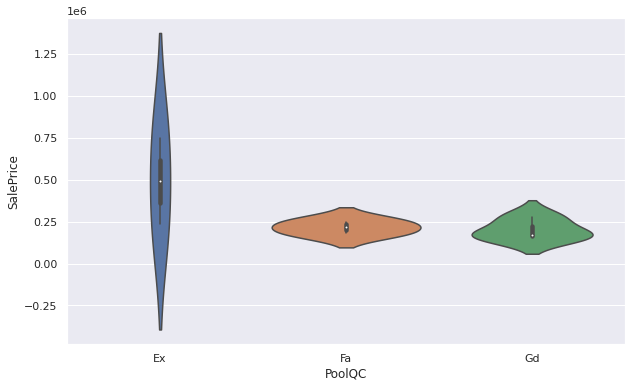

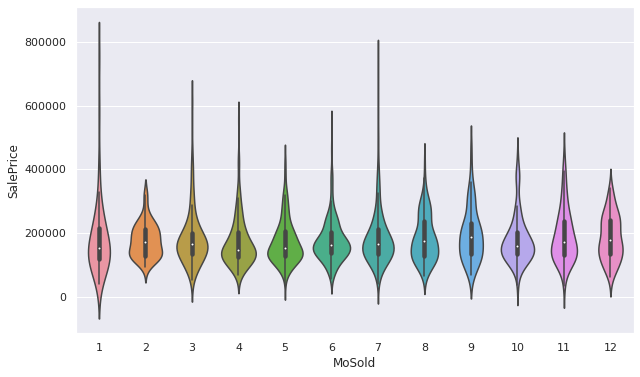

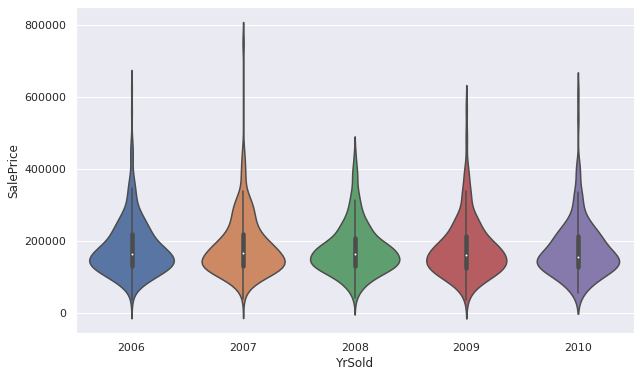

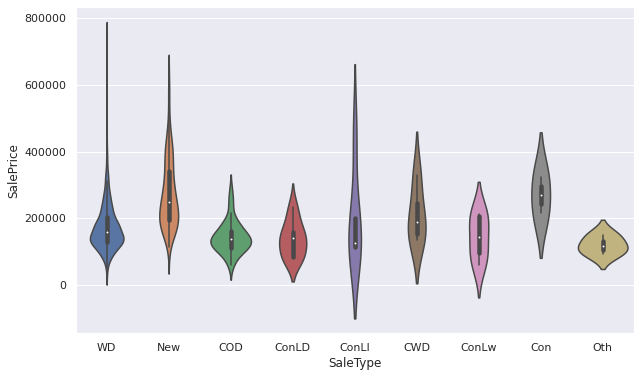

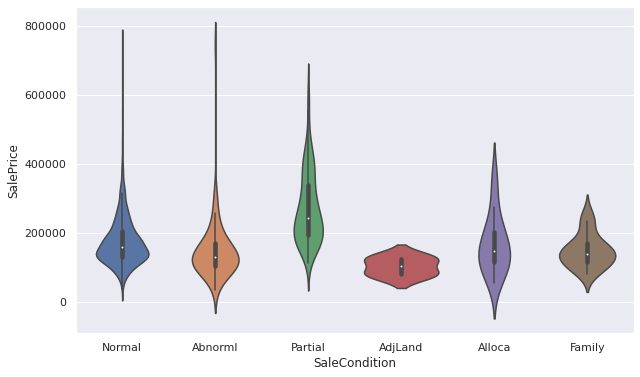

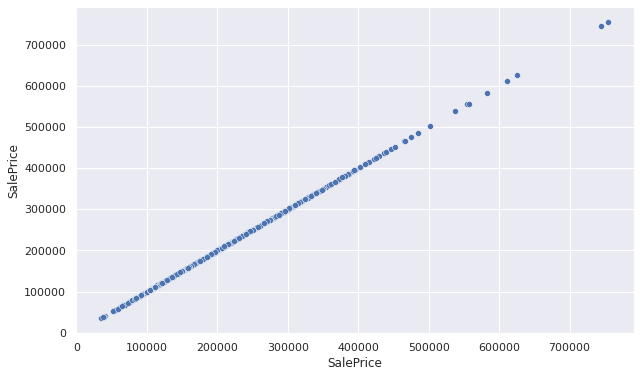

In [37]:
for i in train.columns:
    if len(train[i].unique()) < 20:
        sns.violinplot(x=train[i],y=train['SalePrice'])
        plt.show()
    else:
        sns.scatterplot(x=train[i],y=train['SalePrice'])
        plt.show()

In [38]:
#drop only the two largest saleprice data
extreme_ind = train[train['SalePrice'] > 700000].index
data_all = data_all.drop(index=extreme_ind,axis=1)

In [39]:
#Get rid of non-related features
low_correl_col_num = list(Correlation[Correlation['Abs'] < 0.1].index)
try:
    low_correl_col_num.remove('MoSold')
except:
    pass
low_correl_col_cat = ['Street','LotShape','Utilities','LotConfig','LandSlope','RoofStyle']
#Possible Interaction
data_all = data_all.drop(columns=low_correl_col_num+low_correl_col_cat+['Id','Neighborhood','Sold_time','YrSold'])

# 2.5 Scaling and Transformation

In [40]:
all_num = get_num_features(data_all)
all_cat = get_cat_features(data_all)

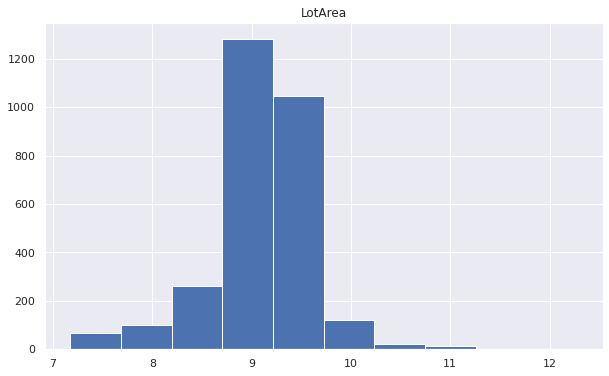

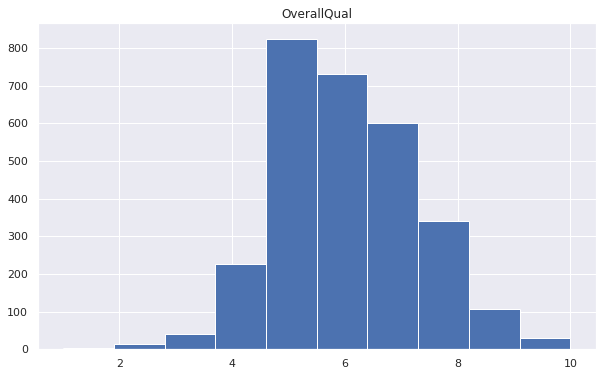

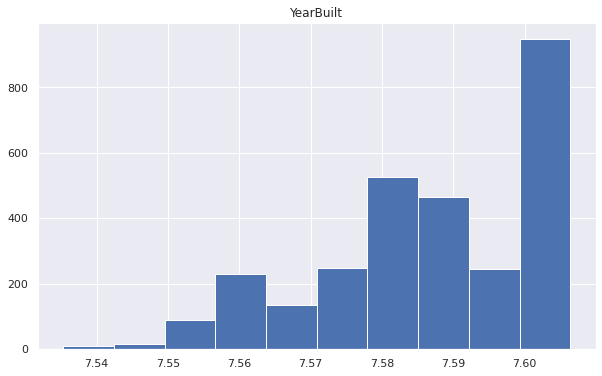

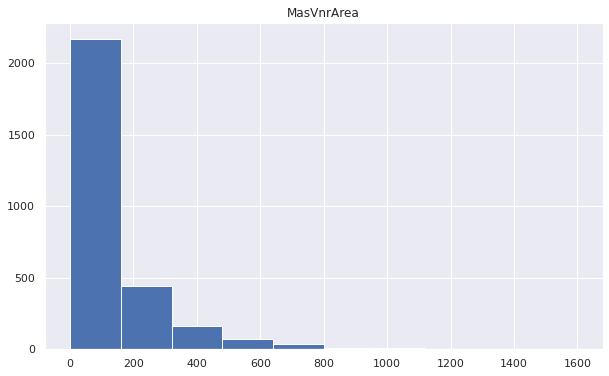

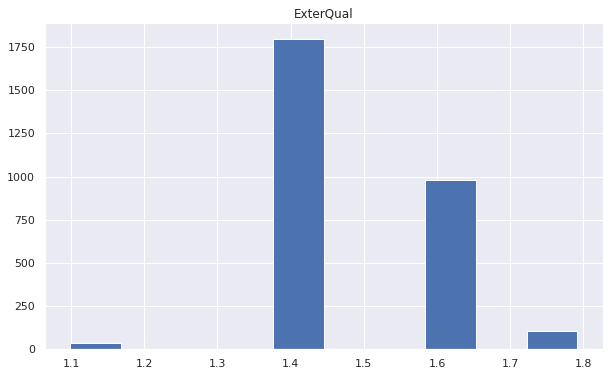

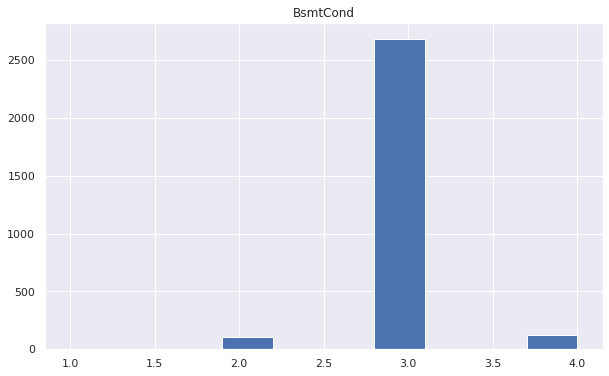

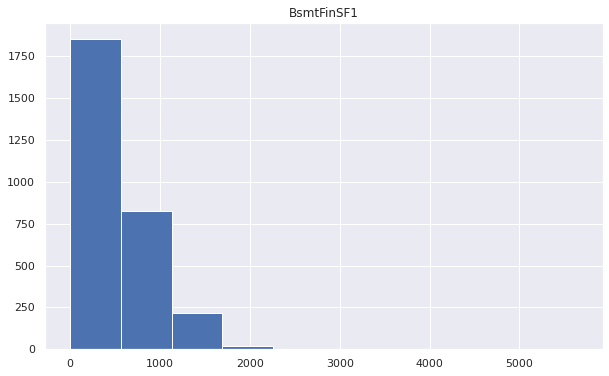

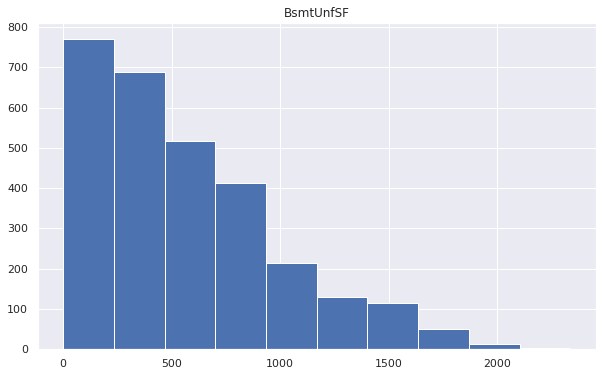

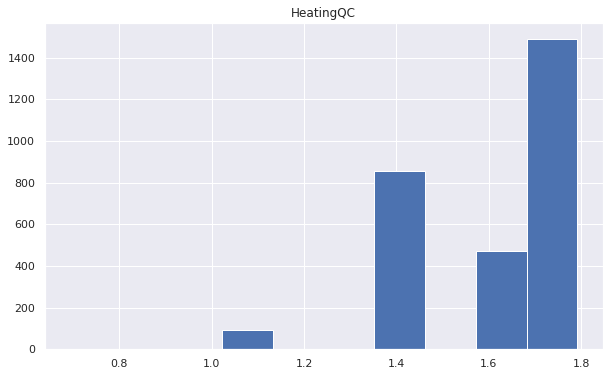

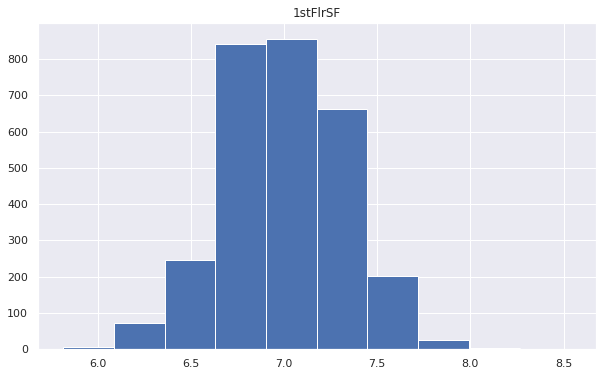

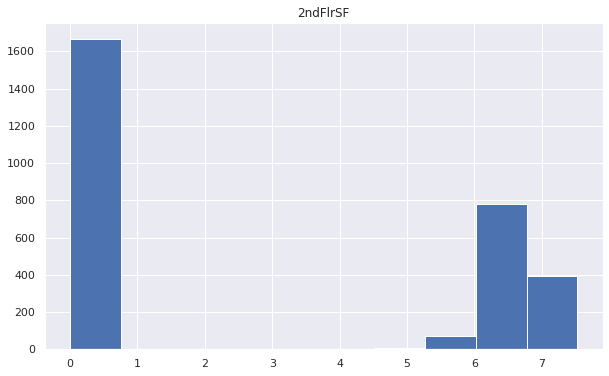

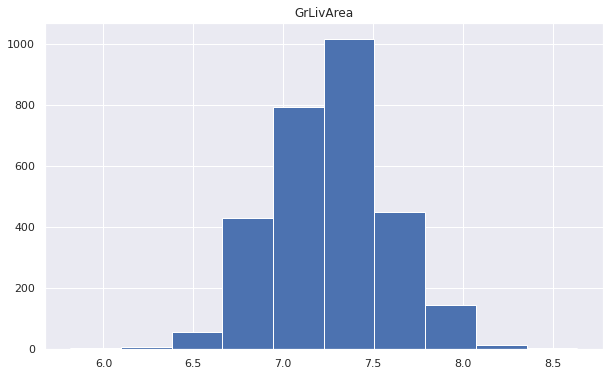

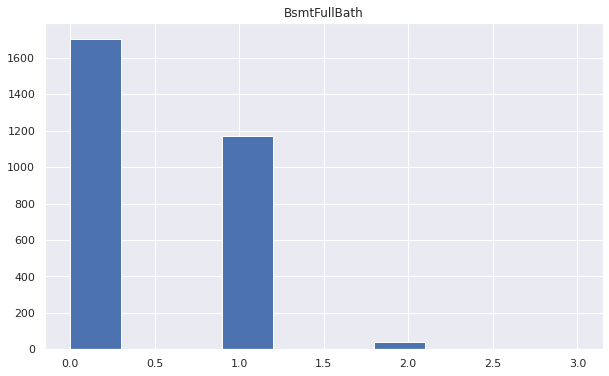

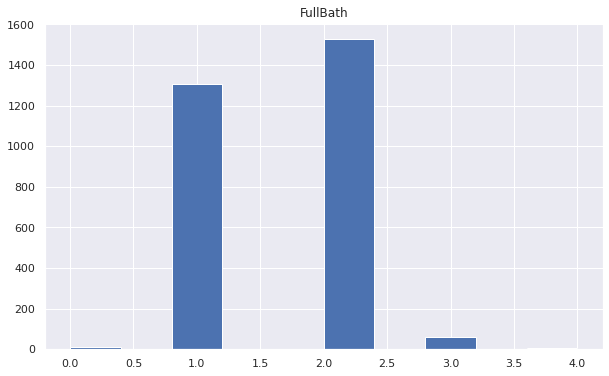

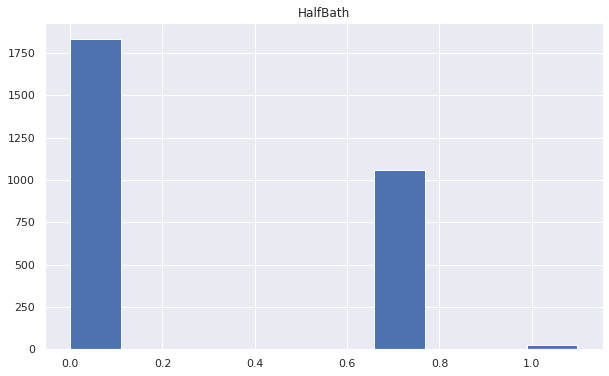

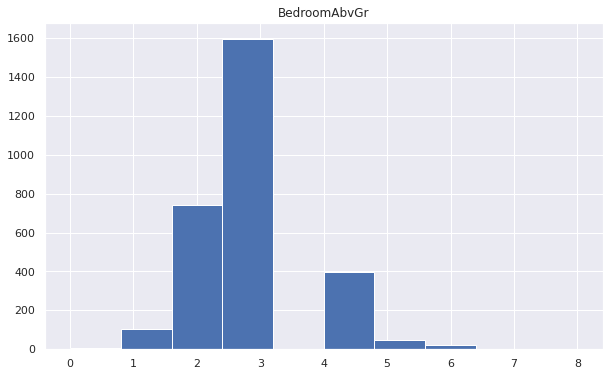

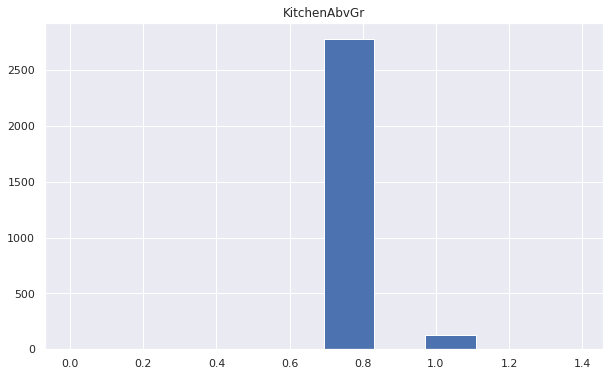

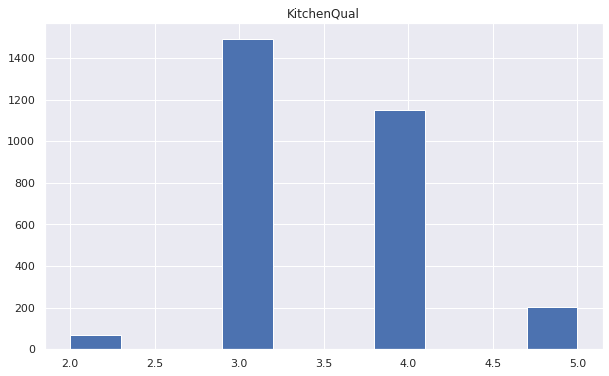

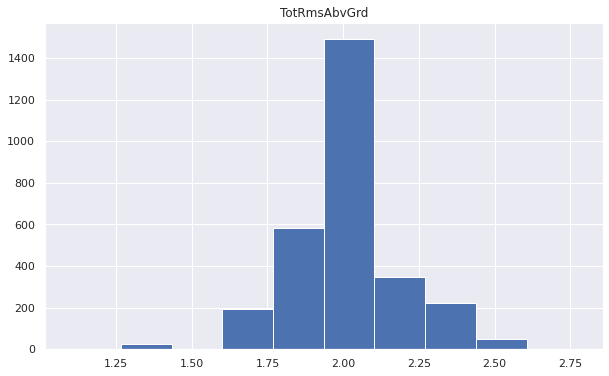

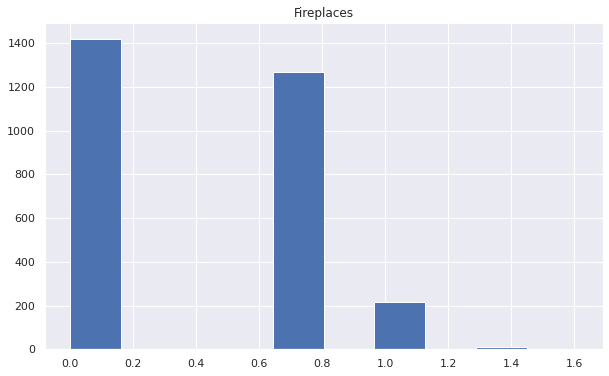

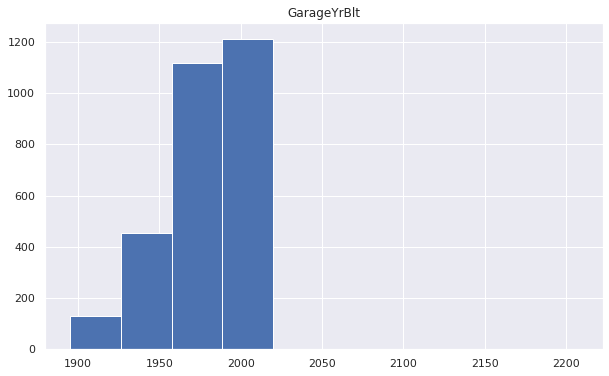

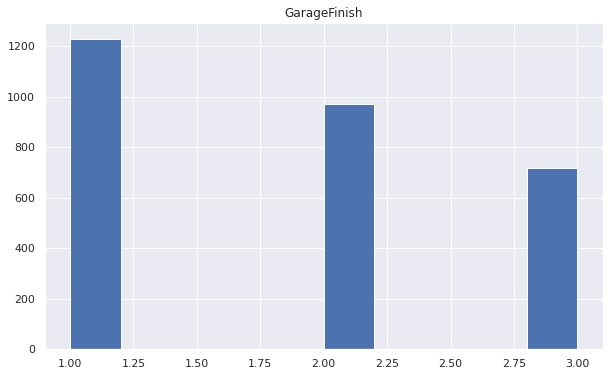

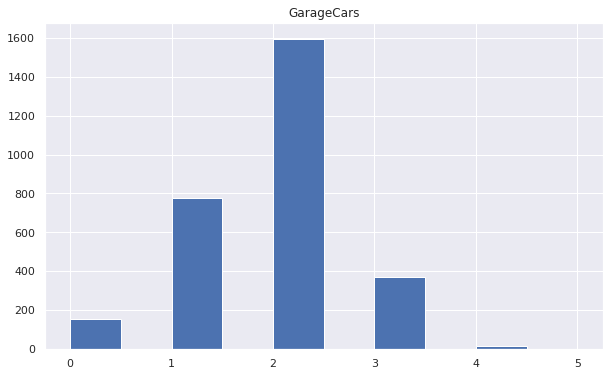

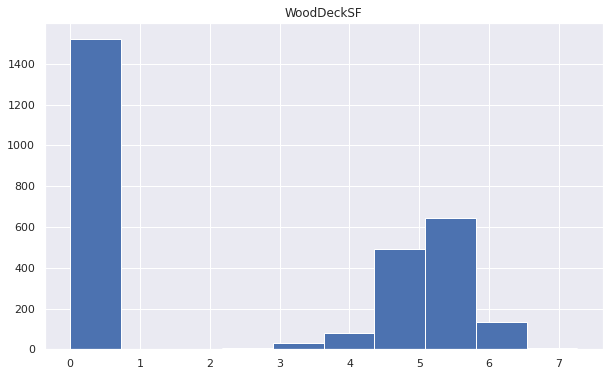

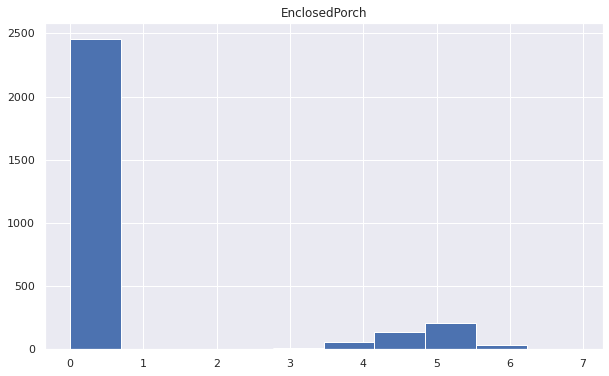

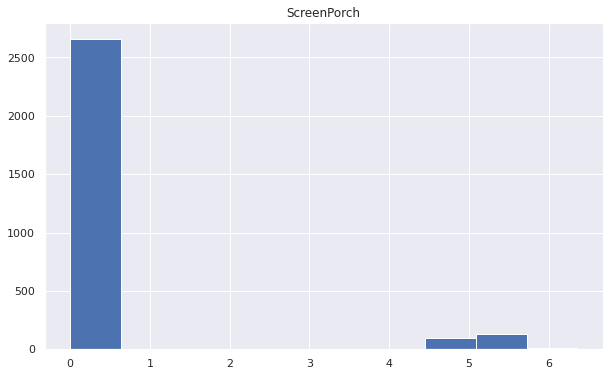

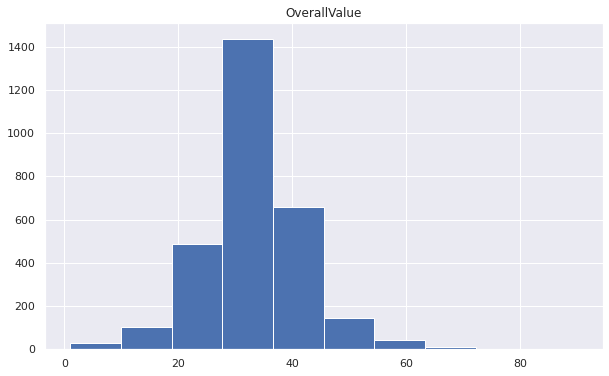

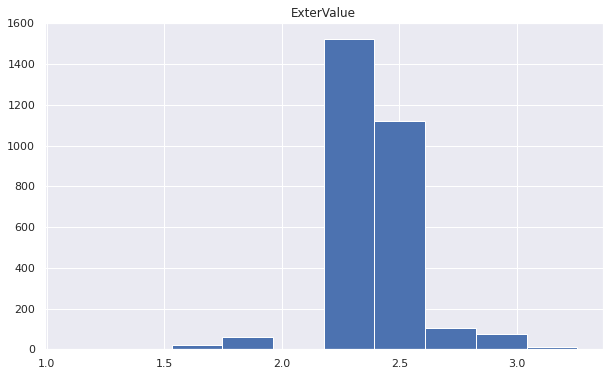

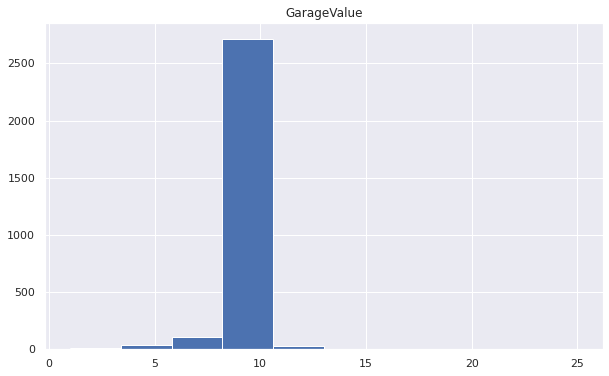

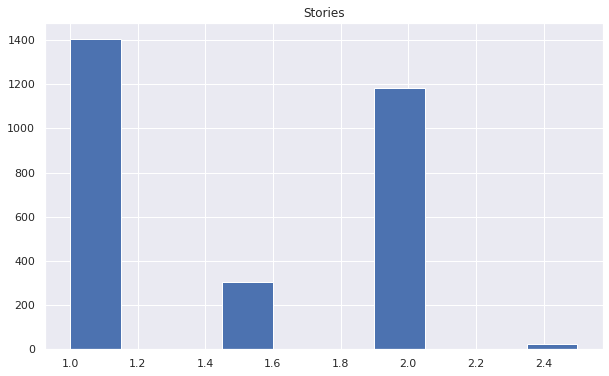

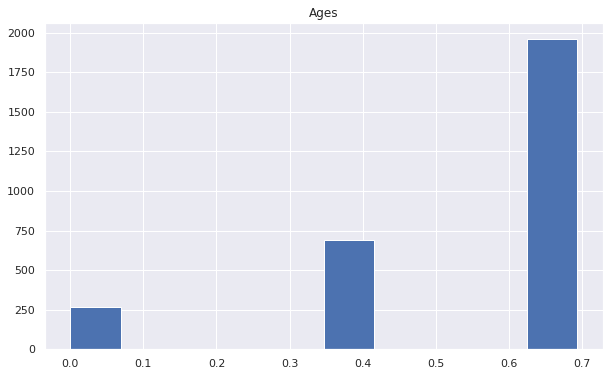

In [41]:
for i in all_num:
    plt.hist(data_all[i])
    plt.title(i)
    plt.show()
#ID not included
#normalize all year feature
#standardized all other numerical feature
#log y

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_col = ['YearRemodAdd','YearBuilt']
data_all[scale_col] = scaler.fit_transform(data_all[scale_col])

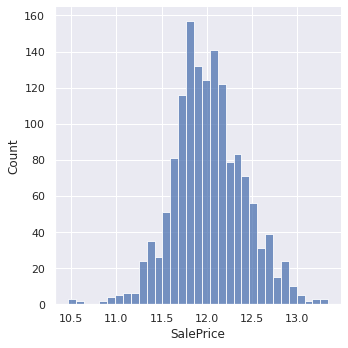

In [43]:
#Considering price should be postive, no trans needed
data_all['SalePrice'] = np.log(data_all['SalePrice'])
sns.displot(data_all['SalePrice'])
plt.show()

> #  3.Preprocessing for Model

In [44]:
#Processing and let ElasticNetRegression build benchmark
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
data_all_processed_x = pd.get_dummies(data_all)
data_all_processed_y = data_all['SalePrice']
y_train = data_all['SalePrice'].dropna()
X_train = data_all_processed_x[~data_all_processed_x['SalePrice'].isnull()].drop(columns='SalePrice')
X_test = data_all_processed_x[data_all_processed_x['SalePrice'].isnull()].drop(columns='SalePrice')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                    test_size=0.2, random_state=20210503)
print('X_train',X_train.shape)
print('X_val',X_val.shape)
print('X_test',X_test.shape)

X_train (1166, 216)
X_val (292, 216)
X_test (1459, 216)


> # 4.Model Building

# 4.1 Try out ElasticNet

Here I use ElasticNet as a bencemary, since it is relatively easier to interpret and it will shrink the coef against collinearity. It would be nice startout to see what you've done above and have a gist of how well you've done. If most of the models won't work out, it may mean that further feature engineering is needed.

In [45]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
ElasticNet = ElasticNet(random_state=0,max_iter=5000)
#scores = -cross_val_score(Ridge, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
parameters = {'alpha':[0.001, 0.0001, 1e-05]}
Grid = GridSearchCV(ElasticNet, parameters, cv=5, scoring='neg_root_mean_squared_error')
results = Grid.fit(X_train,y_train)
print('Best Para:',results.best_params_)
print('Best Score:',abs(results.best_score_))
#print(scores,'\n',np.mean(scores))
print('RMSE:',np.sqrt(mean_squared_error(y_val,results.best_estimator_.predict(X_val))))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02467665063082869, tolerance: 0.014228609367749508
  positive)


Best Para: {'alpha': 0.001}
Best Score: 0.12701960161912268
RMSE: 0.18014705010541737


In [46]:
#Send out Benchline without manually tuning and feature selection
prediction = results.best_estimator_.predict(X_test)

In [47]:
def get_Answer(prediction):
    Answer = pd.DataFrame(np.exp(prediction))
    Answer['Id'] = Answer.index + 1461
    Answer.columns = ['SalePrice','Id']
    Answer = Answer[['Id','SalePrice']]
    return Answer
Answer = get_Answer(prediction)

In [48]:
Answer.to_csv('Submit.csv',index=False)

Take a look at the contribution of the features, does it look similar to what you've expected in EDA.:)?


In [49]:
def get_contribution(estimator):
    Contribution = pd.DataFrame(np.abs(estimator.best_estimator_.coef_))
    Contribution = Contribution.sort_values(by=0,ascending=False)
    Contribution.index = X_train.columns
    Contribution.columns = ['coef']
    return Contribution
def visualize_contribution(df):
    fig,ax=plt.subplots(figsize=(40,20))
    plt.bar(x=df.index,height=df['coef'])
    plt.title('Feature Contribution')
    plt.xticks(rotation=90,fontsize=22)
    plt.show()

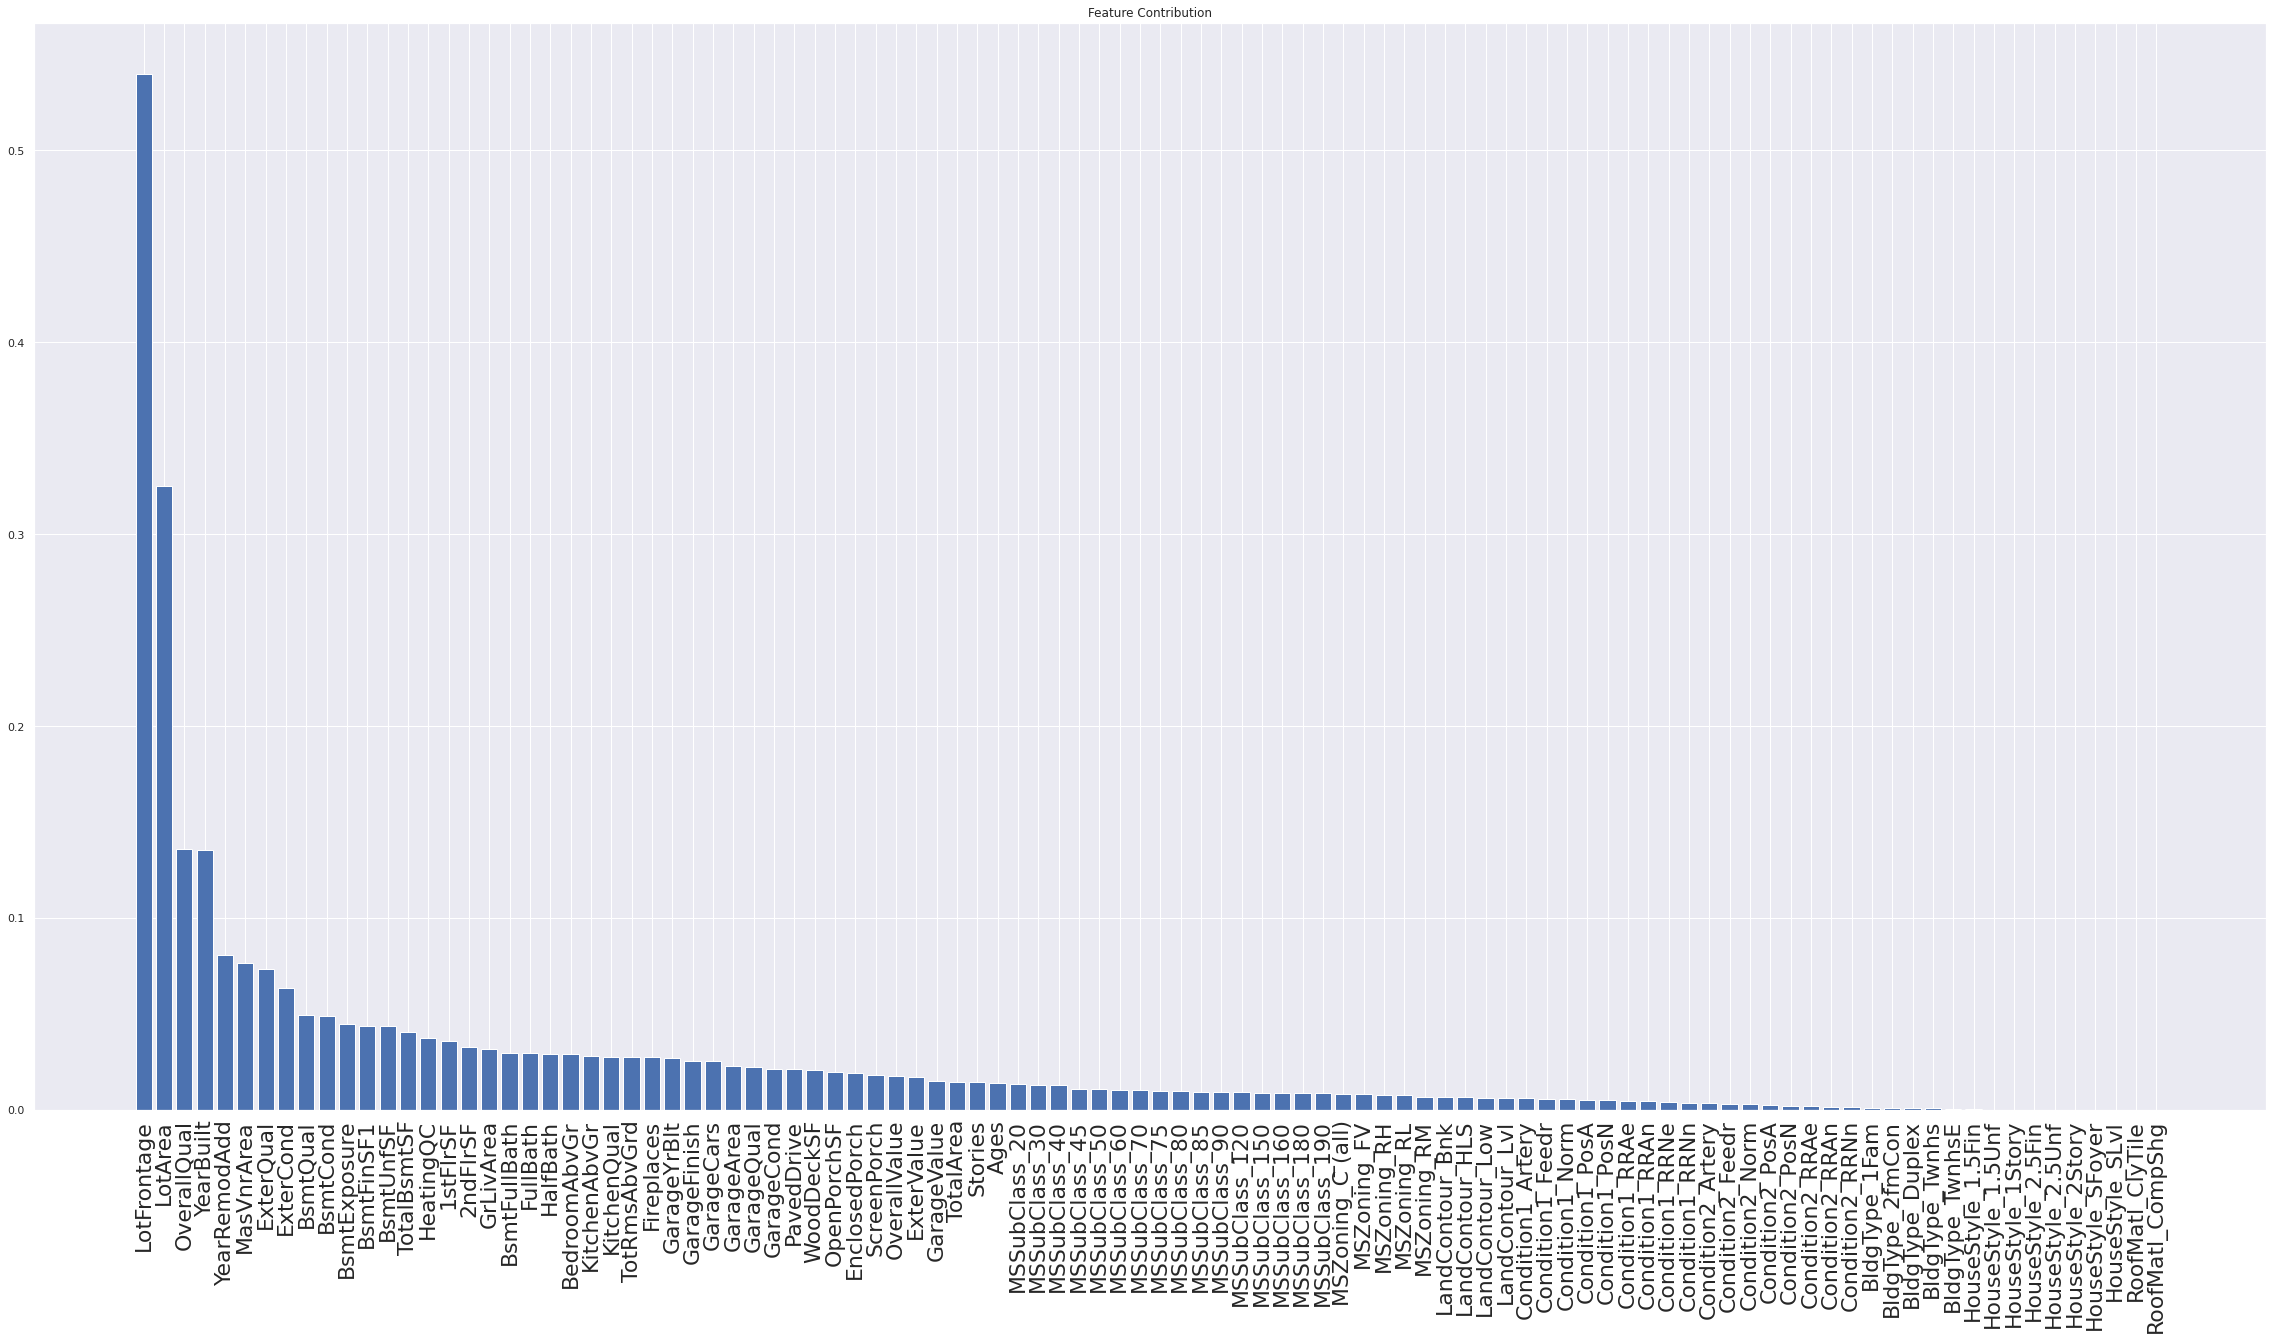

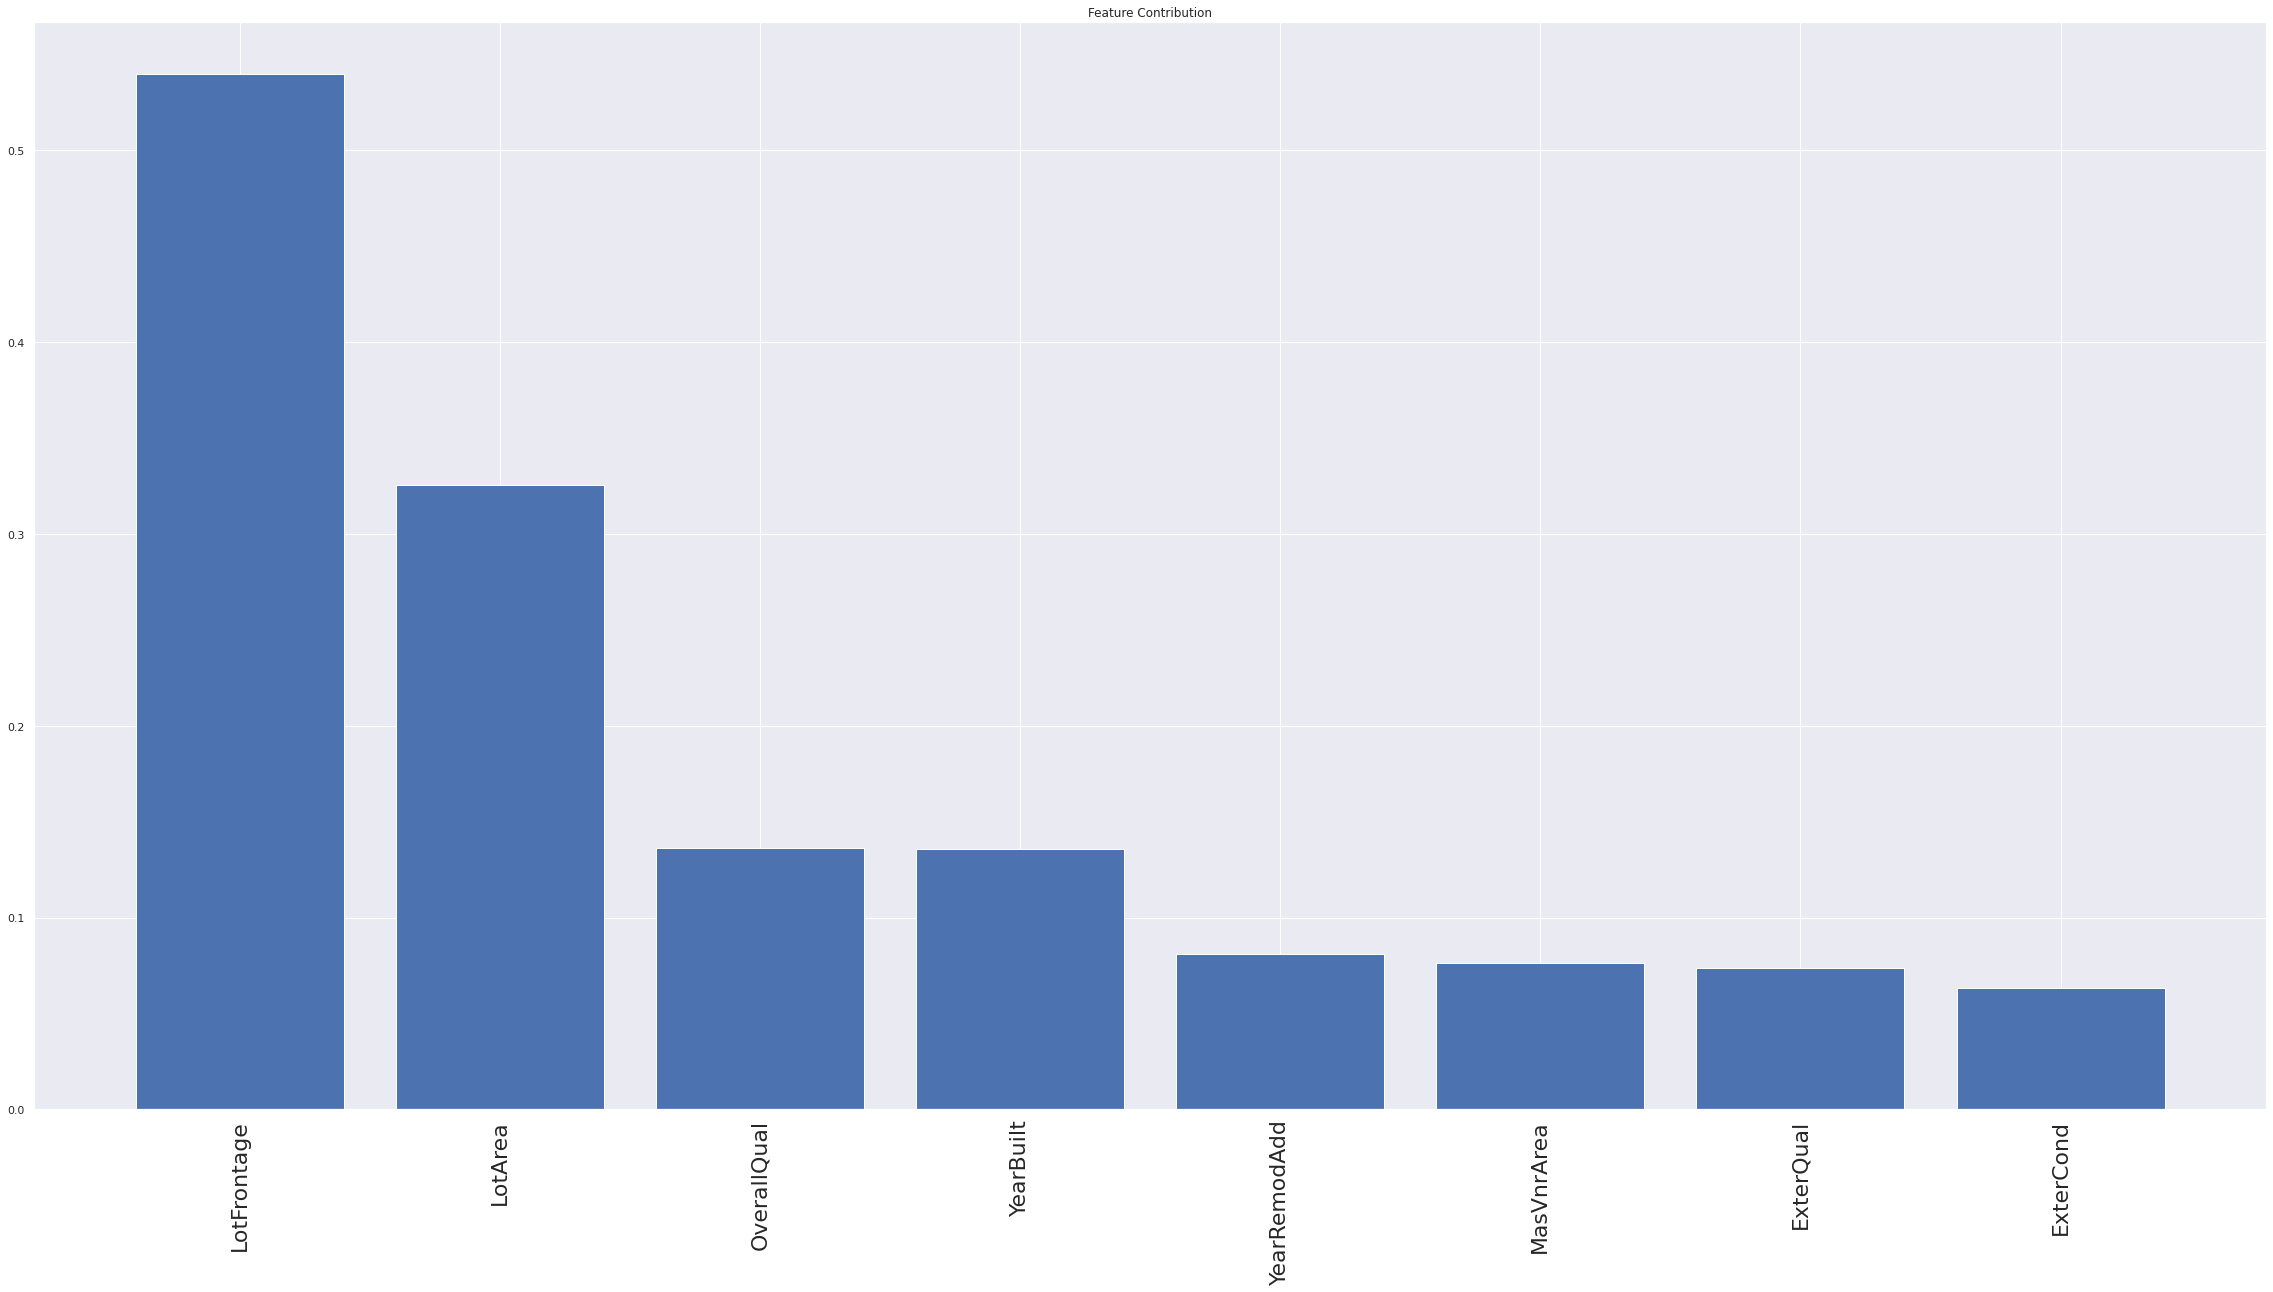

In [50]:
Contribution = get_contribution(results)
visualize_contribution(Contribution[Contribution['coef']>0])
visualize_contribution(Contribution[Contribution['coef']>0.05])

* My benchmark is Ranking 38%, RMSE=0.13 (This is done with just basic data cleansing and no hyperparameter tuning)
* Observed that the RMSE is pretty close(better) to the fitting result

# Steps can be done when the score is not what you desire
* Feature Selection (Create new features)
* Different Preprocessing measure
* Try different Models
* Model Tuning
* Emsemble methods / Stacking

# 4.2 Different Models and scoring metrics

In [51]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [52]:
#1.Tryout Different Models
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
scoring = {'R^2_ad':'r2',
          'R^2':'explained_variance',
          'RMSE':'neg_root_mean_squared_error'}
DecisionTreeRegressor = DecisionTreeRegressor(random_state=0)
print('DecisionTree \n',cross_validate(DecisionTreeRegressor, X_train,y_train, scoring=scoring, cv=5, return_train_score=True))
LGBMRegressor = LGBMRegressor(random_state=0)
print('LGBMRegressor \n',cross_validate(LGBMRegressor, X_train,y_train, scoring=scoring, cv=5, return_train_score=True))
XGBRegressor = XGBRegressor()
print('XGBRegressor \n',cross_validate(XGBRegressor, X_train,y_train, scoring=scoring, cv=5, return_train_score=True))
SVR = SVR()
print('SVR \n',cross_validate(SVR, X_train,y_train, scoring=scoring, cv=5, return_train_score=True))
RandomForestRegressor = RandomForestRegressor()
print('SVR \n',cross_validate(RandomForestRegressor, X_train,y_train, scoring=scoring, cv=5, return_train_score=True))
Ridge = Ridge(random_state=0)
print('Ridge \n',cross_validate(Ridge, X_train,y_train, scoring=scoring, cv=5, return_train_score=True))
Lasso = Lasso(random_state=0)
print('Lasso \n',cross_validate(Lasso, X_train,y_train, scoring=scoring, cv=5, return_train_score=True))
#lgbm seems to have a better performance

DecisionTree 
 {'fit_time': array([0.03696322, 0.03799534, 0.03751707, 0.03710079, 0.0381937 ]), 'score_time': array([0.00633097, 0.00601292, 0.00581169, 0.0059154 , 0.00577664]), 'test_R^2_ad': array([0.70075716, 0.78417719, 0.63923894, 0.7067667 , 0.65460615]), 'train_R^2_ad': array([1., 1., 1., 1., 1.]), 'test_R^2': array([0.70984365, 0.78492911, 0.64122584, 0.70762261, 0.6556289 ]), 'train_R^2': array([1., 1., 1., 1., 1.]), 'test_RMSE': array([-0.2205414 , -0.18814858, -0.2205159 , -0.21453448, -0.22343186]), 'train_RMSE': array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -1.00727955e-16,
       -0.00000000e+00])}
LGBMRegressor 
 {'fit_time': array([0.24433756, 0.20038462, 0.19937992, 0.18198657, 0.19447947]), 'score_time': array([0.00777674, 0.00696182, 0.00705528, 0.00684881, 0.00708175]), 'test_R^2_ad': array([0.8702524 , 0.87470638, 0.84609948, 0.86755513, 0.88961514]), 'train_R^2_ad': array([0.98790758, 0.98847368, 0.98759264, 0.99027458, 0.9862945 ]), 'test_R^2': arra

In [53]:
prediction = results.best_estimator_.predict(X_test)
Answer =  get_Answer(prediction)

In [54]:
Answer.to_csv('Submit.csv',index=False)

In [55]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
lgb_model = lgb.LGBMRegressor(colsample_bytree=0.25, learning_rate=0.01,
                              max_depth=13, min_child_samples=7, n_estimators=10000,
                              num_leaves=20, objective='regression', random_state=42)
xgb_model = xgb.XGBRegressor(colsample_bytree=0.25, gamma=0.0, learning_rate=0.01, max_depth=3,
                             n_estimators=15000, n_jobs=-1, random_state=42, 
                             reg_alpha=0.25, reg_lambda=0.4, subsample=1.0)
gbr_model = GradientBoostingRegressor(alpha=0.9,
                                      learning_rate=0.01, loss='huber',
                                      max_depth=13, max_features=0.1, min_samples_split=110,
                                      n_estimators=10000, n_iter_no_change=100, random_state=42)
svr_model = SVR(C=0.75, coef0=0.0001, degree=2, epsilon=0.0001, gamma=0.005, max_iter=10000)
lasso_model = Lasso(alpha=0.0001, max_iter=5000, random_state=42)
ridge_model = Ridge(alpha=2.5, max_iter=5000, random_state=42)
enet_model = ElasticNet(alpha=0.0002, l1_ratio=0.65, max_iter=5000, random_state=42)
models = [lgb_model,xgb_model,gbr_model,svr_model,lasso_model,ridge_model,enet_model]

In [56]:
for i in models:
    i.fit(X_train,y_train)
    print(str(i)+'RMSE:',np.sqrt(mean_squared_error(y_val,i.predict(X_val))))

LGBMRegressor(colsample_bytree=0.25, learning_rate=0.01, max_depth=13,
              min_child_samples=7, n_estimators=10000, num_leaves=20,
              objective='regression', random_state=42)RMSE: 0.11365390969627447
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.25, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=15000, n_jobs=-1, num_parallel_tree=1,
             random_state=42, reg_alpha=0.25, reg_lambda=0.4,
             scale_pos_weight=1, subsample=1.0, tree_method='exact',
             validate_parameters=1, verbosity=None)RMSE: 0.10793536243953555
GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=13,
                          max_features=0.1, min_samples_split=110,
                 

# 4.3 Ensemble Methods and Submission

In [57]:
#Simple Ensemble with the top 3 algorithm
xgb_model.fit(pd.concat([X_train,X_val]),pd.concat([y_train,y_val]))
lgb_model.fit(pd.concat([X_train,X_val]),pd.concat([y_train,y_val]))
gbr_model.fit(pd.concat([X_train,X_val]),pd.concat([y_train,y_val]))
prediction = xgb_model.predict(X_test) * 0.4 + lgb_model.predict(X_test) * 0.3 + gbr_model.predict(X_test) * 0.3 
get_Answer(prediction).to_csv('0511_0237.csv',index=False)

This result ends up scoring Top15% with 0.12301 RMSE

Here is a sample code for Stacking. Since it's a practice I opt for simple average-ish emsemble method.

In [58]:
#Stacking
from sklearn.ensemble import StackingRegressor
base_models = [('Elastic',ElasticNet()),
             ('SVR',SVR()),
             ('XGB',XGBRegressor),
             ('DecisionTree',DecisionTreeRegressor),
              ('RandomForest',RandomForestRegressor)]

Stacking = StackingRegressor(
     estimators=base_models,
     final_estimator=LGBMRegressor)

Stacking.fit(X_train,y_train)
print('RMSE:',np.sqrt(mean_squared_error(y_val,Stacking.predict(X_val))))

RMSE: 0.13656690636762892
